# **Foundations of Deep Learning  -  Concrete Crack Dataset**


*Giovanni Cornacchia    830631 <br>
*Paolo Guerini Rocco    826236 <br>
*Alberto Gadda          824029 <br>

*Date of delivery: 20/06/2021






Google Drive folder with trained models:
https://drive.google.com/drive/folders/18Ol8Qfe77kKXWyXcHYOesMV4GeL3dtpb?usp=sharing

#  **Libreries & Settings** 

## **Libreries**  

In [ ]:
#Python version: 3.7.13

import shutil
from shutil import copyfile
from time import time
import numpy as np
import pandas as pd
from distutils.dir_util import copy_tree
import cv2
from scipy import stats
from tensorflow import keras
from matplotlib import pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from skimage.morphology import skeletonize
from collections import Counter
import joblib
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import tensorflow as tf
from time import time
import math
import itertools

## **Settings for prettier visualization in Google Colab**

In [ ]:
from IPython.display import Javascript
def resize_colab_cell():
  display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'))
get_ipython().events.register('pre_run_cell', resize_colab_cell)

VAL_SPLIT=0.178575
num_classes=2

In [ ]:
def grafico(cf_matrix,name):
  ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

  ax.set_title('Seaborn Confusion Matrix with labels\n\n');
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ');

  ## Ticket labels - List must be in alphabetical order
  ax.xaxis.set_ticklabels(['False','True'])
  ax.yaxis.set_ticklabels(['False','True'])


  ## Display the visualization of the Confusion Matrix.
  # plt.show()
  plt.savefig(name, bbox_inches='tight', pad_inches=0.5)
  copyfile(name, f'gdrive/My Drive/FDL_project/images/CF_{name}')

<IPython.core.display.Javascript object>

## **Collegamento al Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

<IPython.core.display.Javascript object>

Mounted at /content/gdrive


# **DATA AUGMENTATION**

In [ ]:
from time import time
t0 = time()
!unzip gdrive/My\ Drive/FDL_project/old_data.zip > /dev/null
print("File transfer completed in %0.3f sec" % (time() - t0))

<IPython.core.display.Javascript object>

File transfer completed in 9.705 sec


In [ ]:
def get_crack_angle(image_path, kernel_size = (3,3), iterations = 10, threshold = 40, show_plot = False, bucketization = True): # get slope of the crack given an image
    
    img = cv2.imread(image_path) # read image in BGR format
    ref = img.copy() # store preprocessed image as reference
    
    col_fill_proxy = [round(np.mean(img))] * 3 # calculate average color 
    img[np.where(np.std(img,axis=2)>=15)] = np.array(col_fill_proxy) # flatten colored noise
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert to grayscale (only one channel)

    for _ in range(iterations):
        img = cv2.normalize(img, img, 0, 255, cv2.NORM_MINMAX) # normalize
        img = cv2.GaussianBlur(img,kernel_size,cv2.BORDER_DEFAULT) # blur

    v,img = cv2.threshold(img,threshold,255,cv2.THRESH_BINARY) # force to black or white
    img = skeletonize(abs((img-np.min(img))/(np.max(img)-np.min(img))-1)) # inverse colors (forced) and skeletonize
    
    coord = pd.DataFrame({'y': np.where(img==True)[0],'x': np.where(img==True)[1]}) # track x and y axes
    slope, intercept, r, p, std_err = stats.linregress(coord['x'], coord['y']) # interpolate as f(x)=y
    
    angle = math.degrees(math.atan(slope)) # convert slope to angle and from radiants to degrees
    
    if(show_plot):
        ref = cv2.cvtColor(ref, cv2.COLOR_BGR2RGB) # adjust channel order for proper plotting
        plt.imshow(ref) # plot reference image

        if(slope!=0):
            line_min_limit = round(-intercept/slope) # min border of the line to display
            line_max_limit = round((227-intercept)/slope) # max border of the line to display
            line = cv2.line(ref,(line_min_limit,0),(line_max_limit,227),(255, 0, 0), 8) # line to overlay
        else:
            line = cv2.line(ref,(0,intercept),(227,intercept),(255, 0, 0), 8) # line to overlay
            
        plt.imshow(line) # overlay regression crack line
        
    if(bucketization): # diagonal buckets are inverted because y axis is flipped (e.g. NE-SW becomes SE-NW and viceversa)
        
        angle_single_unit = 360 / 16 # each quadrant will be subdivided in 4 parts and allocated as follows: horizontal bucket -> 1 part, vertical bucket -> 1 part, diagonal bucket -> 2 parts 
        
        if(angle <= - 3 * angle_single_unit or angle >= 3 * angle_single_unit):   
            bucket = "N-S"
        elif(angle > angle_single_unit):
            bucket = "NW-SE"
        elif(angle >= -angle_single_unit):
            bucket = "E-W"
        elif(angle > - 3 * angle_single_unit):
            bucket = "NE-SW"
            
        return(bucket)
    
    return(angle)
;

<IPython.core.display.Javascript object>

''

In [ ]:
def generator(image_path, image_flip = True, show_image = False, brightness_delta = 15, contrast_delta = 0.3, white_noise_delta = 30): # edits image for data augmentation purposes
    
    img = cv2.imread(image_path) # read image in BGR format
    brightness_coeff = np.repeat(np.random.randint(-brightness_delta, brightness_delta), 227 * 227 * 3).reshape(227, 227, 3) # generate brightness alteration array
    contrast_coeff = np.repeat(np.random.uniform(1 - contrast_delta, 1 + contrast_delta), 227 * 227 * 3).reshape(227, 227, 3) # generate contrast alteration array
    white_noise = np.random.randint(-white_noise_delta, white_noise_delta, size = (227, 227, 3)) # generate white noise array
    
    if(image_flip): # only used in positive images
        img = cv2.rotate(img, np.random.choice([cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_90_COUNTERCLOCKWISE])) # flip 90° either clockwise or counterclockwise
        
    img = np.clip(img * contrast_coeff + brightness_coeff + white_noise, 0, 255).astype(int) # apply contrast, brighness and white noise
    
    if(show_image):
        return(plt.imshow(img))
        
    return(img)
;

<IPython.core.display.Javascript object>

''

In [ ]:
base_path = 'old_data/' # edit here the dataset location (the following will be relative to this paths)

base_pos_path = base_path + 'Positive/'
base_neg_path = base_path + 'Negative/'

training_pos_path = base_path + 'Training Positive/'
test_pos_path = base_path + 'Test Positive/'
training_neg_path = base_path + 'Training Negative/'
test_neg_path = base_path + 'Test Negative/'

pos_list = os.listdir(base_pos_path) # list of files
pos_num = len(os.listdir(base_pos_path)) # number of files
neg_list = os.listdir(base_neg_path) # list of files
neg_num = len(os.listdir(base_neg_path)) # number of files

os.mkdir(training_pos_path)
os.mkdir(test_pos_path)
os.mkdir(training_neg_path)
os.mkdir(test_neg_path)

np.random.seed(1) # ensure repeatability

training_pos_list = np.random.choice(pos_list, round(pos_num*0.75),replace=False) # create positive training set
test_pos_list = list((Counter(pos_list) - Counter(training_pos_list)).elements()) # the remaining positive files go into the test set
training_neg_list = np.random.choice(neg_list, round(neg_num*0.75),replace=False) # create negative training set
test_neg_list = list((Counter(neg_list) - Counter(training_neg_list)).elements()) # the remaining negative files go into the test set

[shutil.move(base_pos_path + _, training_pos_path) for _ in training_pos_list] # move positive training set to its new folder
[shutil.move(base_pos_path + _, test_pos_path) for _ in test_pos_list] # move positive test set to its new folder
[shutil.move(base_neg_path + _, training_neg_path) for _ in training_neg_list] # move negative training set to its new folder
[shutil.move(base_neg_path + _, test_neg_path) for _ in test_neg_list] # move negative test set to its new folder

# os.rmdir(base_pos_path)
# os.rmdir(base_neg_path)
;

<IPython.core.display.Javascript object>

''

In [ ]:
crack_buckets = np.array([get_crack_angle(training_pos_path + _) for _ in training_pos_list]) # calculate slope bucket for each image
class_dist = np.unique(crack_buckets, return_counts=True) # distribution of orientation classes
threshold = round(np.ceil(max(class_dist[1]) / 1000) * 1000) # set arbitrary threshold to 7000 elements per class
class_deficiency = np.vectorize(lambda x: threshold - x)(class_dist[1]) # count how many images to add per class to reach threshold
class_source = [class_dist[0][_ + (1 - _ % 2 * 2)] for _ in range(len(class_dist[0]))] # source from where the additional images will be taken (i.e. the opposite orientation rotated by 180°)
source_supply = [class_deficiency[_ + (1 - _ % 2 * 2)] for _ in range(len(class_deficiency))] # number of images that the class provides to the opposite
augmentation_coeff = class_deficiency / class_dist[1] # how many times will each class be augmented
source_representativity_coeff = (class_dist[1] + source_supply) / sum(class_dist[1] + source_supply) # how much a class (intended as source images plus its generated images) weigths on the total images
representativity_coeff_diff = source_representativity_coeff - class_dist[1] / sum(class_dist[1]) # difference between the source representativity of each class post and pre data augmentation
;

<IPython.core.display.Javascript object>

''

In [ ]:
np.random.seed(2) # ensure repeatability

pos_augmentation_selection = list(itertools.chain(*[np.random.choice(training_pos_list[np.where(np.array(crack_buckets) == class_source[_])], class_deficiency[_], replace = False) for _ in range(len(class_deficiency))])) # select positive data to augment
[cv2.imwrite(training_pos_path + 'AUG_' + _, generator(training_pos_path + _)) for _ in pos_augmentation_selection] # store augmented positive data

neg_augmentation_selection = np.random.choice(training_neg_list, sum(class_deficiency), replace = False) # select negative data to augment (to keep the response variable balanced, the number of new images will be the same)
[cv2.imwrite(training_neg_path + 'AUG_' + _, generator(training_neg_path + _)) for _ in neg_augmentation_selection] # store augmented negative data
;

<IPython.core.display.Javascript object>

''

<IPython.core.display.Javascript object>

''

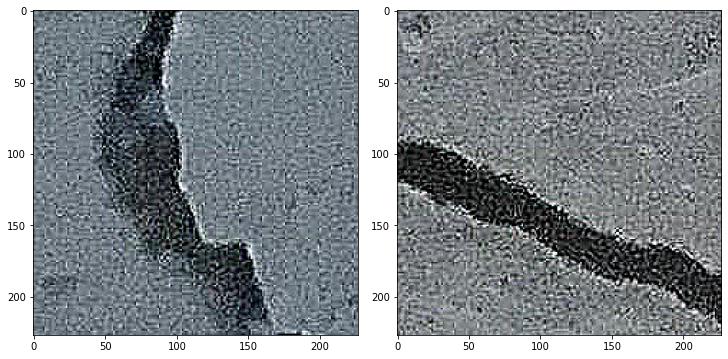

In [ ]:
kernel = np.array([[0, -5, 0],
                  [-5, 21, -5],
                   [0, -5, 0]])

fig, ax = plt.subplots(1, 2, constrained_layout = True)
fig.set_figheight(10)
fig.set_figwidth(10)
ax[0].imshow(cv2.filter2D(src=cv2.imread(training_pos_path + '00068.jpg'), ddepth= -1, kernel=kernel))
ax[1].imshow(cv2.filter2D(src=cv2.imread(training_pos_path + '00174.jpg'), ddepth= -1, kernel=kernel))
;

In [ ]:
# organize folders to ease keras data loader import 
base_test_path = 'new_data/test'
base_training_path = 'new_data/training'

os.mkdir('new_data')
os.mkdir(base_test_path)
os.mkdir(base_training_path)

shutil.move(training_pos_path, base_training_path)
shutil.move(test_pos_path, base_test_path)
shutil.move(training_neg_path, base_training_path)
shutil.move(test_neg_path, base_test_path)

os.rename('new_data/training/Training Positive/', 'new_data/training/Positive/')
os.rename('new_data/training/Training Negative/', 'new_data/training/Negative/')
os.rename('new_data/test/Test Positive/', 'new_data/test/Positive/')
os.rename('new_data/test/Test Negative/', 'new_data/test/Negative/')
;


<IPython.core.display.Javascript object>

''

# **EVALUATION ON DATA AUGMENTATION**

## **DATA AUGMENTATION: NO**

#### **Data Loader: Traning & Validatiion set**

In [ ]:
from time import time
t0 = time()
!unzip gdrive/My\ Drive/FDL_project/old_data.zip > /dev/null
print("File transfer completed in %0.3f sec" % (time() - t0))

base_path ='old_data/'
num_classes=2

train_dataset = keras.preprocessing.image_dataset_from_directory(base_path,
                                                            image_size=(227,227),
                                                            color_mode='rgb',
                                                            batch_size=32,
                                                            label_mode='categorical',
                                                            subset='training',
                                                            validation_split = 0.2,
                                                            shuffle=True,
                                                            seed=1)
val_dataset = keras.preprocessing.image_dataset_from_directory(base_path,
                                                            image_size=(227,227),
                                                            color_mode='rgb',
                                                            batch_size=32,
                                                            label_mode='categorical',
                                                            subset='validation',
                                                            validation_split = 0.2,
                                                            shuffle=True,
                                                            seed=1)


In [ ]:
os.listdir('old_data/Positive')

#### **Architecture Definition**

In [ ]:
inputs = keras.Input((227,227,3))

x = inputs
x = keras.layers.Conv2D(32, 3, padding="same")(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(64, 3, padding="same")(x)
x = keras.layers.Activation("relu")(x)

x = keras.layers.GlobalMaxPooling2D()(x)

outputs = keras.layers.Dense(num_classes, activation="softmax")(x)
net_old = keras.Model(inputs, outputs)


# Compile the model for training
net_old.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy'])



# Model training
history_old = net_old.fit(train_dataset,
          epochs=5,
          validation_data=val_dataset);

#### **Plot Model**

In [ ]:
keras.utils.plot_model(net_old, show_shapes=True)

#### **Saving of the History in Google Drive**

In [ ]:
name='net_1_old_data'
joblib.dump(net_old, f'{name}.sav')
np.save(f'{name}_history.npy',history_old)
copyfile(f'{name}.sav', f'gdrive/My Drive/FDL_project/saves/{name}.sav')
copyfile(f'{name}_history.npy', f'gdrive/My Drive/FDL_project/saves/{name}_history.npy')

#### **Confusion Matrix**

In [ ]:
labels = np.array([])
pred = np.array([])
for x, y in val_dataset:
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])
  pred = np.concatenate([pred, np.argmax(net_old.predict(x), axis=-1)])


fpr, tpr, _ = roc_curve(labels, pred)
print(f'Sensitivity: {tpr[1]}')
cf_matrix = confusion_matrix(labels, pred)
grafico(cf_matrix, 'net_old.png')

## **DATA AUGMENTATION: SI**





#### **Data Loader: Traning & Validatiion set**

In [ ]:
num_classes=2
train_path='new_data/training'
train_dataset = keras.preprocessing.image_dataset_from_directory(train_path,
                                                            image_size=(227,227),
                                                            color_mode='rgb',
                                                            batch_size=32,
                                                            label_mode='categorical',
                                                            subset='training',
                                                            validation_split = VAL_SPLIT,
                                                            shuffle=True,
                                                            seed=1)

val_dataset = keras.preprocessing.image_dataset_from_directory(train_path,
                                                            image_size=(227,227),
                                                            color_mode='rgb',
                                                            batch_size=32,
                                                            label_mode='categorical',
                                                            subset='validation',
                                                            validation_split = VAL_SPLIT,
                                                            shuffle=True,
                                                            seed=1)



#### **Architecture Definition**

In [ ]:
# Architecture definition v1
inputs = keras.Input((227,227,3)) #raw,columns,channels(RGB)

x = inputs
x = keras.layers.Conv2D(32, 3, padding="same")(x) #32 filters 3x3, "same" chose automatically the padding dimension
x = keras.layers.Activation("relu")(x) #activation function is ReLU
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x) #filter dimension = 3, stripe = 3

x = keras.layers.Conv2D(64, 3, padding="same")(x) #altro layer convoluzionale
x = keras.layers.Activation("relu")(x)

x = keras.layers.GlobalMaxPooling2D()(x)

outputs = keras.layers.Dense(num_classes, activation="softmax")(x) #output layer, we use softmax cause is the common one
net = keras.Model(inputs, outputs) #construction of the model


# Compile the model for training
net.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy'])




# Model training (v1)
history = net.fit(train_dataset,
          epochs=5,
          validation_data=val_dataset);

#### **Saving of the History in Google Drive**

In [ ]:
name='net_1_new_data'
joblib.dump(net, f'{name}.sav')
np.save(f'{name}_history.npy',history)
copyfile(f'{name}.sav', f'gdrive/My Drive/FDL_project/saves/{name}.sav')
copyfile(f'{name}_history.npy', f'gdrive/My Drive/FDL_project/saves/{name}_history.npy')

#### **Confusion Matrix**

In [ ]:
labels = np.array([])
pred = np.array([])
for x, y in val_dataset:
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])
  pred = np.concatenate([pred, np.argmax(net.predict(x), axis=-1)])


fpr, tpr, _ = roc_curve(labels, pred)
print(f'Sensitivity: {tpr[1]}')
cf_matrix = confusion_matrix(labels, pred)
grafico(cf_matrix, 'net_new.png')

## **Visualization of the learning curves**



##### **Loss**







In [ ]:
#Plot the loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history_old.history['loss'])
plt.ylim([0.0, 0.5])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train_new', 'train_old' ])

plt.subplot(1, 2, 2)
plt.plot(history.history['val_loss'])
plt.plot(history_old.history['val_loss'])
plt.ylim([0.0, 0.5])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['valid_new','valid_old' ])


##### **Accuracy**

In [ ]:
#plot the accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history_old.history['accuracy'])
plt.ylim([0.7, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train_new', 'train_old' ])

plt.subplot(1, 2, 2)
plt.plot(history.history['val_accuracy'])
plt.plot(history_old.history['val_accuracy'])
plt.ylim([0.7, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['valid_new','valid_old' ])

# **DIMENSION**

## **wide and shallow**.

### **Architecture Definition**


In [ ]:
# Architecture definition v1
inputs = keras.Input((227,227,3)) #raw,columns,channels(RGB)

x = inputs
x = keras.layers.Conv2D(64, 3, padding="same")(x) #32 filters 3x3, "same" chose automatically the padding dimension
x = keras.layers.Activation("relu")(x) #activation function is ReLU
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x) #filter dimension = 3, stripe = 3

x = keras.layers.Conv2D(128, 3, padding="same")(x) #altro layer convoluzionale
x = keras.layers.Activation("relu")(x)


x = keras.layers.GlobalMaxPooling2D()(x)

outputs = keras.layers.Dense(num_classes, activation="softmax")(x) #output layer, we use softmax cause is the common one
net_large = keras.Model(inputs, outputs) #construction of the model


# Compile the model for training
net_large.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy'])


# Model training (v1)
history_large = net_large.fit(train_dataset,
          epochs=10,
          validation_data=val_dataset);

<IPython.core.display.Javascript object>

Epoch 1/10
1750/1750 [==============================] - 141s 80ms/step - loss: 0.4775 - accuracy: 0.9424 - val_loss: 0.2258 - val_accuracy: 0.9262
Epoch 2/10
1750/1750 [==============================] - 139s 79ms/step - loss: 0.1092 - accuracy: 0.9704 - val_loss: 0.0450 - val_accuracy: 0.9852
Epoch 3/10
1750/1750 [==============================] - 137s 78ms/step - loss: 0.0915 - accuracy: 0.9767 - val_loss: 0.0737 - val_accuracy: 0.9747
Epoch 4/10
1750/1750 [==============================] - 137s 78ms/step - loss: 0.0774 - accuracy: 0.9797 - val_loss: 0.0292 - val_accuracy: 0.9915
Epoch 5/10
1750/1750 [==============================] - 136s 78ms/step - loss: 0.0744 - accuracy: 0.9813 - val_loss: 0.0369 - val_accuracy: 0.9880
Epoch 6/10
1750/1750 [==============================] - 135s 77ms/step - loss: 0.0680 - accuracy: 0.9827 - val_loss: 0.1503 - val_accuracy: 0.9620
Epoch 7/10
1750/1750 [==============================] - 133s 76ms/step - loss: 0.0642 - accuracy: 0.9841 - val_loss: 0

### **Saving of the History in Google Drive**


In [ ]:
name='net_large_1_new_data'
joblib.dump(net_large, f'{name}.sav')
np.save(f'{name}_history.npy',history_large)
copyfile(f'{name}.sav', f'gdrive/My Drive/FDL_project/saves/{name}.sav')
copyfile(f'{name}_history.npy', f'gdrive/My Drive/FDL_project/saves/{name}_history.npy')

<IPython.core.display.Javascript object>

INFO:tensorflow:Assets written to: ram://f5d10c0d-989f-4dde-a84e-fd4afbb75329/assets
INFO:tensorflow:Assets written to: ram://a8208fbc-1d84-40a0-9ba3-0ce5901cc006/assets


'gdrive/My Drive/FDL_project/saves/net_short_1_new_data_history.npy'

### **Confusion Matrix**

In [ ]:
labels = np.array([])
pred = np.array([])
for x, y in val_dataset:
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])
  pred = np.concatenate([pred, np.argmax(net_large.predict(x), axis=-1)])


fpr, tpr, _ = roc_curve(labels, pred)
print(f'Sensitivity: {tpr[1]}')
cf_matrix = confusion_matrix(labels, pred)
grafico(cf_matrix, 'net_large.png')

## **narrower and deeper**

### **Architecture Definition**


In [ ]:
inputs = keras.Input((227,227,3)) 

x = inputs
x = keras.layers.Conv2D(8, 3, padding="same")(x) 
x = keras.layers.Activation("relu")(x) 
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x) 

x = keras.layers.Conv2D(16, 3, padding="same")(x) 
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x) 

x = keras.layers.Conv2D(32, 3, padding="same")(x) 
x = keras.layers.Activation("relu")(x)


x = keras.layers.GlobalMaxPooling2D()(x)

outputs = keras.layers.Dense(num_classes, activation="softmax")(x) 
net_long = keras.Model(inputs, outputs) 


# Compile the model for training
net_long.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy'])


# Model training 
history_long = net_long.fit(train_dataset,
          epochs=10,
          validation_data=val_dataset);

<IPython.core.display.Javascript object>

Epoch 1/10
1750/1750 [==============================] - 81s 46ms/step - loss: 0.1691 - accuracy: 0.9575 - val_loss: 0.0450 - val_accuracy: 0.9853
Epoch 2/10
1750/1750 [==============================] - 92s 52ms/step - loss: 0.0549 - accuracy: 0.9830 - val_loss: 0.0326 - val_accuracy: 0.9891
Epoch 3/10
1750/1750 [==============================] - 83s 47ms/step - loss: 0.0441 - accuracy: 0.9869 - val_loss: 0.0301 - val_accuracy: 0.9912
Epoch 4/10
1750/1750 [==============================] - 75s 43ms/step - loss: 0.0403 - accuracy: 0.9881 - val_loss: 0.0313 - val_accuracy: 0.9918
Epoch 5/10
1750/1750 [==============================] - 76s 43ms/step - loss: 0.0391 - accuracy: 0.9891 - val_loss: 0.0262 - val_accuracy: 0.9922
Epoch 6/10
1750/1750 [==============================] - 74s 42ms/step - loss: 0.0397 - accuracy: 0.9893 - val_loss: 0.0227 - val_accuracy: 0.9929
Epoch 7/10
1750/1750 [==============================] - 74s 42ms/step - loss: 0.0353 - accuracy: 0.9905 - val_loss: 0.0260 -

### **Saving of the History in Google Drive**


In [ ]:
name='net_long_1_new_data'
joblib.dump(net_long, f'{name}.sav')
np.save(f'{name}_history.npy',history_long)
copyfile(f'{name}.sav', f'gdrive/My Drive/FDL_project/saves/{name}.sav')
copyfile(f'{name}_history.npy', f'gdrive/My Drive/FDL_project/saves/{name}_history.npy')

<IPython.core.display.Javascript object>

INFO:tensorflow:Assets written to: ram://d078acd8-d3c0-432e-b882-5cecbed0949c/assets
INFO:tensorflow:Assets written to: ram://b11beca8-aedf-42e8-9699-6a29a6a2a572/assets


'gdrive/My Drive/FDL_project/saves/net_long_1_new_data_history.npy'

### **Confusion Matrix**

In [ ]:
labels = np.array([])
pred = np.array([])
for x, y in val_dataset:
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])
  pred = np.concatenate([pred, np.argmax(net_long.predict(x), axis=-1)])


fpr, tpr, _ = roc_curve(labels, pred)
print(f'Sensitivity: {tpr[1]}')
cf_matrix = confusion_matrix(labels, pred)
grafico(cf_matrix, 'net_long.png')

### **Visualization of the learning curves**

#### **Loss**

<IPython.core.display.Javascript object>

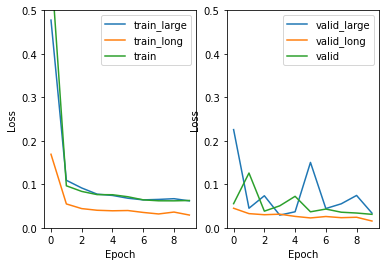

In [ ]:
#Plot the loss
plt.subplot(1, 2, 1)
plt.plot(history_large.history['loss'])
plt.plot(history_long.history['loss'])
plt.plot(history.history['loss'])
plt.ylim([0.0, 0.5])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train_large', 'train_long','train' ])

plt.subplot(1, 2, 2)
plt.plot(history_large.history['val_loss'])
plt.plot(history_long.history['val_loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0.0, 0.5])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['valid_large','valid_long','valid' ])
plt.savefig('long_vs_large_loss.png')

#### **Accuracy**

<IPython.core.display.Javascript object>

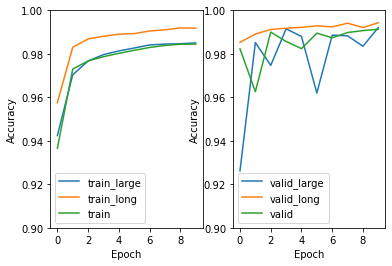

In [ ]:
#plot the accuracy
plt.subplot(1, 2, 1)
plt.plot(history_large.history['accuracy'])
plt.plot(history_long.history['accuracy'])
plt.plot(history.history['accuracy'])
plt.ylim([0.9, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train_large', 'train_long','train' ])

plt.subplot(1, 2, 2)
plt.plot(history_large.history['val_accuracy'])
plt.plot(history_long.history['val_accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([0.9, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['valid_large','valid_long','valid' ])
plt.savefig('long_vs_large_accuracy.png')


##**both long and wide**

### **Architecture Definition**


In [ ]:
# Architecture definition v1
inputs = keras.Input((227,227,3)) #raw,columns,channels(RGB)

x = inputs
x = keras.layers.Conv2D(32, 3, padding="same")(x) #32 filters 3x3, "same" chose automatically the padding dimension
x = keras.layers.Activation("relu")(x) #activation function is ReLU
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x) #filter dimension = 3, stripe = 3

x = keras.layers.Conv2D(64, 3, padding="same")(x) #altro layer convoluzionale
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x) #filter dimension = 3, stripe = 3

x = keras.layers.Conv2D(128, 3, padding="same")(x) #altro layer convoluzionale
x = keras.layers.Activation("relu")(x)


x = keras.layers.GlobalMaxPooling2D()(x)

outputs = keras.layers.Dense(num_classes, activation="softmax")(x) #output layer, we use softmax cause is the common one
net_long_large = keras.Model(inputs, outputs) #construction of the model


# Compile the model for training
net_long_large.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy'])


# Model training (v1)
history_long_large = net_long_large.fit(train_dataset,
          epochs=10,
          validation_data=val_dataset);

<IPython.core.display.Javascript object>

Epoch 1/10
1750/1750 [==============================] - 100s 56ms/step - loss: 0.4736 - accuracy: 0.9579 - val_loss: 0.0607 - val_accuracy: 0.9832
Epoch 2/10
1750/1750 [==============================] - 109s 62ms/step - loss: 0.0617 - accuracy: 0.9840 - val_loss: 0.0240 - val_accuracy: 0.9921
Epoch 3/10
1750/1750 [==============================] - 89s 51ms/step - loss: 0.0501 - accuracy: 0.9874 - val_loss: 0.0468 - val_accuracy: 0.9874
Epoch 4/10
1750/1750 [==============================] - 86s 49ms/step - loss: 0.0443 - accuracy: 0.9894 - val_loss: 0.0280 - val_accuracy: 0.9918
Epoch 5/10
1750/1750 [==============================] - 84s 48ms/step - loss: 0.0398 - accuracy: 0.9901 - val_loss: 0.0228 - val_accuracy: 0.9936
Epoch 6/10
1750/1750 [==============================] - 86s 49ms/step - loss: 0.0362 - accuracy: 0.9918 - val_loss: 0.0183 - val_accuracy: 0.9944
Epoch 7/10
1750/1750 [==============================] - 84s 48ms/step - loss: 0.0418 - accuracy: 0.9905 - val_loss: 0.0236

### **Saving of the History in Google Drive**


In [ ]:
name='net_long_large_1_new_data'
joblib.dump(net_long_large, f'{name}.sav')
np.save(f'{name}_history.npy',history_long_large)
copyfile(f'{name}.sav', f'gdrive/My Drive/FDL_project/saves/{name}.sav')
copyfile(f'{name}_history.npy', f'gdrive/My Drive/FDL_project/saves/{name}_history.npy')

<IPython.core.display.Javascript object>

INFO:tensorflow:Assets written to: ram://b44dd6b6-d39f-439c-a483-ac5c7c98aab4/assets
INFO:tensorflow:Assets written to: ram://50211f88-c6cd-49b0-bc39-7ea10212e2ee/assets


'gdrive/My Drive/FDL_project/saves/net_long_large_1_new_data_history.npy'

 ### **Confusion Matrix**


In [ ]:
labels = np.array([])
pred = np.array([])
for x, y in val_dataset:
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])
  pred = np.concatenate([pred, np.argmax(net_long_large.predict(x), axis=-1)])


fpr, tpr, _ = roc_curve(labels, pred)
print(f'Sensitivity: {tpr[1]}')
cf_matrix = confusion_matrix(labels, pred)
grafico(cf_matrix, 'net_long_large.png')

### **Visualization of the learning curves**


#### **Loss**


<IPython.core.display.Javascript object>

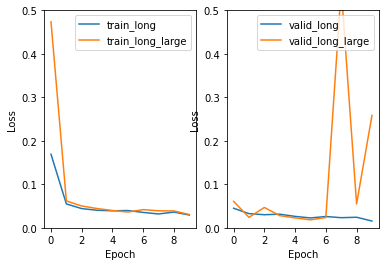

In [ ]:
#Plot the loss
plt.subplot(1, 2, 1)
plt.plot(history_long.history['loss'])
plt.plot(history_long_large.history['loss'])
plt.ylim([0.0, 0.5])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train_long', 'train_long_large' ])

plt.subplot(1, 2, 2)
plt.plot(history_long.history['val_loss'])
plt.plot(history_long_large.history['val_loss'])
plt.ylim([0.0, 0.5])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['valid_long','valid_long_large' ])
plt.savefig('long_and_large_loss.png')

#### **Accuracy**


<IPython.core.display.Javascript object>

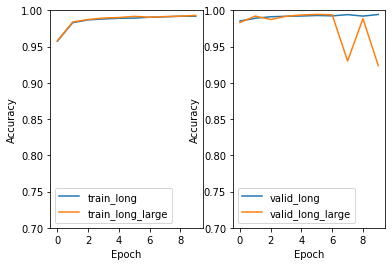

In [ ]:
#plot the accuracy
plt.subplot(1, 2, 1)
plt.plot(history_long.history['accuracy'])
plt.plot(history_long_large.history['accuracy'])
plt.ylim([0.7, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train_long', 'train_long_large' ])

plt.subplot(1, 2, 2)
plt.plot(history_long.history['val_accuracy'])
plt.plot(history_long_large.history['val_accuracy'])
plt.ylim([0.7, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['valid_long','valid_long_large' ])
plt.savefig('long_and_large_accuracy.png')

## **even longer**

In [ ]:
num_classes=2

<IPython.core.display.Javascript object>

### **Architecture Definition**


In [ ]:
# Architecture definition v1
inputs = keras.Input((227,227,3)) #raw,columns,channels(RGB)

x = inputs
x = keras.layers.Conv2D(8, 3, padding="same")(x) #32 filters 3x3, "same" chose automatically the padding dimension
x = keras.layers.Activation("relu")(x) #activation function is ReLU
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x) #filter dimension = 3, stripe = 3

x = keras.layers.Conv2D(16, 3, padding="same")(x) #altro layer convoluzionale
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x) #filter dimension = 3, stripe = 3

x = keras.layers.Conv2D(16, 3, padding="same")(x) #altro layer convoluzionale
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x) #filter dimension = 3, stripe = 3

x = keras.layers.Conv2D(32, 3, padding="same")(x) #altro layer convoluzionale
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x) #filter dimension = 3, stripe = 3

x = keras.layers.Conv2D(32, 3, padding="same")(x) #altro layer convoluzionale
x = keras.layers.Activation("relu")(x)

x = keras.layers.GlobalMaxPooling2D()(x)

outputs = keras.layers.Dense(num_classes, activation="softmax")(x) #output layer, we use softmax cause is the common one
net_more_long = keras.Model(inputs, outputs) #construction of the model


# Compile the model for training
net_more_long.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy'])


# Model training (v1)
history_more_long = net_more_long.fit(train_dataset,
          epochs=10,
          validation_data=val_dataset);

### **Saving of the History in Google Drive**


In [ ]:
name='net_more_long_1_new_data'
joblib.dump(net_more_long, f'{name}.sav')
np.save(f'{name}_history.npy',history_more_long)
copyfile(f'{name}.sav', f'gdrive/My Drive/FDL_project/saves/{name}.sav')
copyfile(f'{name}_history.npy', f'gdrive/My Drive/FDL_project/saves/{name}_history.npy')

### **Confusion Matrix**

In [ ]:
labels = np.array([])
pred = np.array([])
for x, y in val_dataset:
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])
  pred = np.concatenate([pred, np.argmax(net_more_long.predict(x), axis=-1)])


fpr, tpr, _ = roc_curve(labels, pred)
print(f'Sensitivity: {tpr[1]}')
cf_matrix = confusion_matrix(labels, pred)
grafico(cf_matrix, 'net_more_long.png')

### **Visualization of the learning curves**


#### **Loss**


<IPython.core.display.Javascript object>

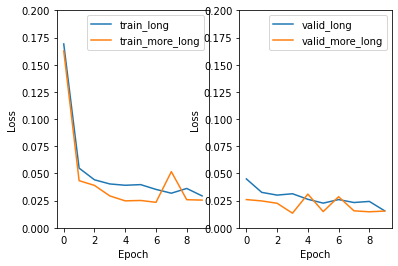

In [ ]:
#Plot the loss
plt.subplot(1, 2, 1)
plt.plot(history_long.history['loss'])
plt.plot(history_more_long.history['loss'])
plt.ylim([0.0, 0.2])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train_long', 'train_more_long' ])

plt.subplot(1, 2, 2)
plt.plot(history_long.history['val_loss'])
plt.plot(history_more_long.history['val_loss'])
plt.ylim([0.0, 0.2])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['valid_long','valid_more_long' ])
plt.savefig('long_and_more_long_loss.png')

#### **Accuracy**


<IPython.core.display.Javascript object>

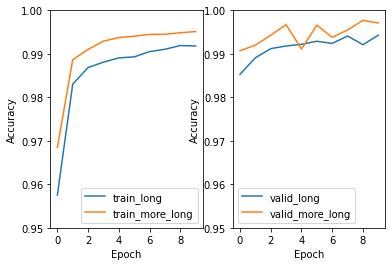

In [ ]:
#plot the accuracy
plt.subplot(1, 2, 1)
plt.plot(history_long.history['accuracy'])
plt.plot(history_more_long.history['accuracy'])
plt.ylim([0.95, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train_long', 'train_more_long' ])

plt.subplot(1, 2, 2)
plt.plot(history_long.history['val_accuracy'])
plt.plot(history_more_long.history['val_accuracy'])
plt.ylim([0.95, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['valid_long','valid_more_long' ])
plt.savefig('long_and_more_long_accuracy.png')

# **KERNEL SIZE**

## **Architecture Definition**


In [ ]:
# Architecture definition v1
inputs = keras.Input((227,227,3)) #raw,columns,channels(RGB)

x = inputs
x = keras.layers.Conv2D(8, 5, padding="same")(x) #32 filters 3x3, "same" chose automatically the padding dimension
x = keras.layers.Activation("relu")(x) #activation function is ReLU
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x) #filter dimension = 3, stripe = 3

x = keras.layers.Conv2D(16, 5, padding="same")(x) #altro layer convoluzionale
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x) #filter dimension = 3, stripe = 3

x = keras.layers.Conv2D(16, 5, padding="same")(x) #altro layer convoluzionale
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x) #filter dimension = 3, stripe = 3

x = keras.layers.Conv2D(32, 5, padding="same")(x) #altro layer convoluzionale
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x) #filter dimension = 3, stripe = 3

x = keras.layers.Conv2D(32, 5, padding="same")(x) #altro layer convoluzionale
x = keras.layers.Activation("relu")(x)

x = keras.layers.GlobalMaxPooling2D()(x)

outputs = keras.layers.Dense(num_classes, activation="softmax")(x) #output layer, we use softmax cause is the common one
net_kernel = keras.Model(inputs, outputs) #construction of the model


# Compile the model for training
net_kernel.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy'])


# Model training (v1)
history_kernel = net_kernel.fit(train_dataset,
          epochs=10,
          validation_data=val_dataset);

## **Saving of the History in Google Drive**


In [ ]:
name='net_kernel_1_new_data'
joblib.dump(net_kernel, f'{name}.sav')
np.save(f'{name}_history.npy',history_kernel)
copyfile(f'{name}.sav', f'gdrive/My Drive/FDL_project/saves/{name}.sav')
copyfile(f'{name}_history.npy', f'gdrive/My Drive/FDL_project/saves/{name}_history.npy')

 ## **Confusion Matrix**


In [ ]:
labels = np.array([])
pred = np.array([])
for x, y in val_dataset:
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])
  pred = np.concatenate([pred, np.argmax(net_kernel.predict(x), axis=-1)])


fpr, tpr, _ = roc_curve(labels, pred)
print(f'Sensitivity: {tpr[1]}')
cf_matrix = confusion_matrix(labels, pred)
grafico(cf_matrix, 'net_kernel.png')

## **Visualization of the learning curves**


### **Loss**


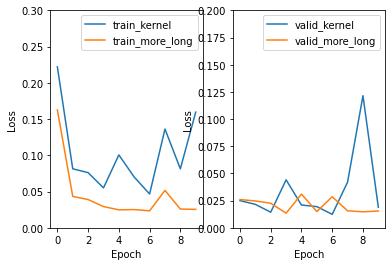

In [ ]:
#Plot the loss
plt.subplot(1, 2, 1)
plt.plot(history_kernel.history['loss'])
plt.plot(history_more_long.history['loss'])
plt.ylim([0.0, 0.3])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train_kernel', 'train_more_long' ])

plt.subplot(1, 2, 2)
plt.plot(history_kernel.history['val_loss'])
plt.plot(history_more_long.history['val_loss'])
plt.ylim([0.0, 0.2])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['valid_kernel','valid_more_long' ])
plt.savefig('kernel_loss.png')

### **Accuracy**


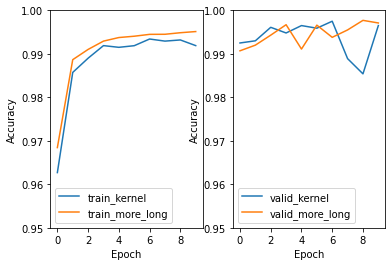

In [ ]:
#plot the accuracy
plt.subplot(1, 2, 1)
plt.plot(history_kernel.history['accuracy'])
plt.plot(history_more_long.history['accuracy'])
plt.ylim([0.95, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train_kernel', 'train_more_long' ])

plt.subplot(1, 2, 2)
plt.plot(history_kernel.history['val_accuracy'])
plt.plot(history_more_long.history['val_accuracy'])
plt.ylim([0.95, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['valid_kernel','valid_more_long' ])
plt.savefig('kernel_accuracy.png')

PER IL MOMENTO IL MIGLIORE E' **MORE_LONG**, TRANNE CHE PER LA SPECIFICITY DOVE IL MIGLIORE E' **LONG_LARGE**

# **NORMALIZATION**

## **Architecture Definition**


In [ ]:
# Architecture definition v1
inputs = keras.Input((227,227,3)) #raw,columns,channels(RGB)

x = inputs
x = keras.layers.Conv2D(8, 3, padding="same")(x) #32 filters 3x3, "same" chose automatically the padding dimension
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x) #activation function is ReLU
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x) #filter dimension = 3, stripe = 3

x = keras.layers.Conv2D(16, 3, padding="same")(x) #altro layer convoluzionale
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x) #filter dimension = 3, stripe = 3

x = keras.layers.Conv2D(16, 3, padding="same")(x) #altro layer convoluzionale
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x) #filter dimension = 3, stripe = 3

x = keras.layers.Conv2D(32, 3, padding="same")(x) #altro layer convoluzionale
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x) #filter dimension = 3, stripe = 3

x = keras.layers.Conv2D(32, 3, padding="same")(x) #altro layer convoluzionale
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)

x = keras.layers.GlobalMaxPooling2D()(x)

outputs = keras.layers.Dense(num_classes, activation="softmax")(x) #output layer, we use softmax cause is the common one
net_norm = keras.Model(inputs, outputs) #construction of the model


# Compile the model for training
net_norm.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy'])


# Model training (v1)
history_norm = net_norm.fit(train_dataset,
          epochs=10,
          validation_data=val_dataset);

<IPython.core.display.Javascript object>

Epoch 1/10
1750/1750 [==============================] - 78s 43ms/step - loss: 0.0228 - accuracy: 0.9927 - val_loss: 0.0069 - val_accuracy: 0.9981
Epoch 2/10
1750/1750 [==============================] - 77s 44ms/step - loss: 0.0105 - accuracy: 0.9971 - val_loss: 0.0078 - val_accuracy: 0.9980
Epoch 3/10
1750/1750 [==============================] - 78s 44ms/step - loss: 0.0072 - accuracy: 0.9977 - val_loss: 0.0060 - val_accuracy: 0.9982
Epoch 4/10
1750/1750 [==============================] - 76s 43ms/step - loss: 0.0063 - accuracy: 0.9981 - val_loss: 0.0061 - val_accuracy: 0.9989
Epoch 5/10
1750/1750 [==============================] - 78s 44ms/step - loss: 0.0052 - accuracy: 0.9986 - val_loss: 0.0060 - val_accuracy: 0.9990
Epoch 6/10
1750/1750 [==============================] - 76s 44ms/step - loss: 0.0044 - accuracy: 0.9987 - val_loss: 0.0082 - val_accuracy: 0.9986
Epoch 7/10
1750/1750 [==============================] - 76s 43ms/step - loss: 0.0042 - accuracy: 0.9989 - val_loss: 0.0066 -

## **Saving of the History in Google Drive**


In [ ]:
name='net_norm_1_new_data'
joblib.dump(net_norm, f'{name}.sav')
np.save(f'{name}_history.npy',history_norm)
copyfile(f'{name}.sav', f'gdrive/My Drive/FDL_project/saves/{name}.sav')
copyfile(f'{name}_history.npy', f'gdrive/My Drive/FDL_project/saves/{name}_history.npy')

<IPython.core.display.Javascript object>

INFO:tensorflow:Assets written to: ram://13465eed-daaf-428f-bb17-de2fd0b0aecf/assets
INFO:tensorflow:Assets written to: ram://f17c3eb6-919c-4eed-9dd0-2613a17c9e9c/assets


'gdrive/My Drive/FDL_project/saves/net_norm_1_new_data_history.npy'

 ## **Confusion Matrix**


<IPython.core.display.Javascript object>

Sensitivity: 0.9986


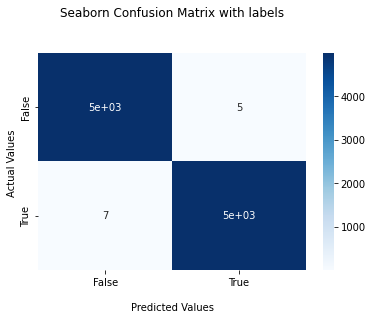

In [ ]:
labels = np.array([])
pred = np.array([])
for x, y in val_dataset:
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])
  pred = np.concatenate([pred, np.argmax(net_norm.predict(x), axis=-1)])


fpr, tpr, _ = roc_curve(labels, pred)
print(f'Sensitivity: {tpr[1]}')
cf_matrix = confusion_matrix(labels, pred)
grafico(cf_matrix, 'net_norm.png')

## **Visualization of the learning curves**


### **Loss**


<IPython.core.display.Javascript object>

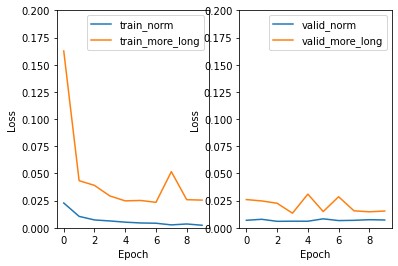

In [ ]:
#Plot the loss
plt.subplot(1, 2, 1)
plt.plot(history_norm.history['loss'])
plt.plot(history_more_long.history['loss'])
plt.ylim([0.0, 0.2])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train_norm', 'train_more_long' ])

plt.subplot(1, 2, 2)
plt.plot(history_norm.history['val_loss'])
plt.plot(history_more_long.history['val_loss'])
plt.ylim([0.0, 0.2])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['valid_norm','valid_more_long' ])
plt.savefig('norm_loss.png')

### **Accuracy**


<IPython.core.display.Javascript object>

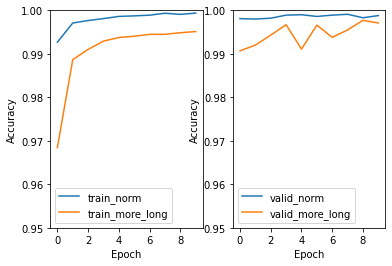

In [ ]:
#plot the accuracy
plt.subplot(1, 2, 1)
plt.plot(history_norm.history['accuracy'])
plt.plot(history_more_long.history['accuracy'])
plt.ylim([0.95, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train_norm', 'train_more_long' ])

plt.subplot(1, 2, 2)
plt.plot(history_norm.history['val_accuracy'])
plt.plot(history_more_long.history['val_accuracy'])
plt.ylim([0.95, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['valid_norm','valid_more_long' ])
plt.savefig('norm_accuracy.png')

In [ ]:
# Architecture definition v1
inputs = keras.Input((227,227,3)) #raw,columns,channels(RGB)

x = inputs
x = keras.layers.Conv2D(8, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x) #32 filters 3x3, "same" chose automatically the padding dimension
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x) #activation function is ReLU
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x) #filter dimension = 3, stripe = 3

x = keras.layers.Conv2D(16, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x) #altro layer convoluzionale
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x) #filter dimension = 3, stripe = 3

x = keras.layers.Conv2D(16, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x) #altro layer convoluzionale
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x) #filter dimension = 3, stripe = 3

x = keras.layers.Conv2D(32, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x) #altro layer convoluzionale
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x) #filter dimension = 3, stripe = 3

x = keras.layers.Conv2D(32, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x) #altro layer convoluzionale
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)

x = keras.layers.GlobalMaxPooling2D()(x)

outputs = keras.layers.Dense(num_classes, activation="softmax")(x) #output layer, we use softmax cause is the common one
net_norm_reg_l2 = keras.Model(inputs, outputs) #construction of the model


# Compile the model for training
net_norm_reg_l2.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy'])


# Model training (v1)
history_norm_reg_l2 = net_norm_reg_l2.fit(train_dataset,
          epochs=15,
          validation_data=val_dataset);

#**NORMALIZATION + REGULARIZATION**

## **l2**

### **Architecture Definition**


In [ ]:
# Architecture definition v1
inputs = keras.Input((227,227,3)) #raw,columns,channels(RGB)

x = inputs
x = keras.layers.Conv2D(8, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x) #32 filters 3x3, "same" chose automatically the padding dimension
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x) #activation function is ReLU
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x) #filter dimension = 3, stripe = 3

x = keras.layers.Conv2D(16, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x) #altro layer convoluzionale
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x) #filter dimension = 3, stripe = 3

x = keras.layers.Conv2D(16, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x) #altro layer convoluzionale
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x) #filter dimension = 3, stripe = 3

x = keras.layers.Conv2D(32, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x) #altro layer convoluzionale
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x) #filter dimension = 3, stripe = 3

x = keras.layers.Conv2D(32, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x) #altro layer convoluzionale
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)

x = keras.layers.GlobalMaxPooling2D()(x)

outputs = keras.layers.Dense(num_classes, activation="softmax")(x) #output layer, we use softmax cause is the common one
net_norm_reg_l2_20 = keras.Model(inputs, outputs) #construction of the model


# Compile the model for training
net_norm_reg_l2_20.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy'])


# Model training (v1)
history_norm_reg_l2_20 = net_norm_reg_l2_20.fit(train_dataset,
          epochs=20,
          validation_data=val_dataset);

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 1/20
1438/1438 [==============================] - 96s 65ms/step - loss: 0.0720 - accuracy: 0.9907 - val_loss: 0.0338 - val_accuracy: 0.9959
Epoch 2/20
1438/1438 [==============================] - 109s 76ms/step - loss: 0.0292 - accuracy: 0.9956 - val_loss: 0.0193 - val_accuracy: 0.9973
Epoch 3/20
1438/1438 [==============================] - 93s 64ms/step - loss: 0.0240 - accuracy: 0.9963 - val_loss: 0.0365 - val_accuracy: 0.9921
Epoch 4/20
1438/1438 [==============================] - 94s 65ms/step - loss: 0.0206 - accuracy: 0.9962 - val_loss: 0.0179 - val_accuracy: 0.9966
Epoch 5/20
1438/1438 [==============================] - 64s 45ms/step - loss: 0.0194 - accuracy: 0.9967 - val_loss: 0.0143 - val_accuracy: 0.9979
Epoch 6/20
1438/1438 [==============================] - 64s 45ms/step - loss: 0.0184 - accuracy: 0.9966 - val_loss: 0.0154 - val_accuracy: 0.9973
Epoch 7/20
1438/1438 [==============================] - 66s 46ms/step - loss: 0.0180 - accuracy: 0.9966 - val_loss: 0.0160 

### **Saving of the History in Google Drive**


In [ ]:
name='net_norm_reg_l2_20_1_new_data'
joblib.dump(net_norm_reg_l2_20, f'{name}.sav')
np.save(f'{name}_history.npy',history_norm_reg_l2_20)
copyfile(f'{name}.sav', f'gdrive/My Drive/FDL_project/saves/{name}.sav')
copyfile(f'{name}_history.npy', f'gdrive/My Drive/FDL_project/saves/{name}_history.npy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

INFO:tensorflow:Assets written to: ram://9abbfdc9-1d42-45e7-bab9-2ccdf929c417/assets
INFO:tensorflow:Assets written to: ram://387890f0-a40a-4412-929f-1934d70a5b47/assets


'gdrive/My Drive/FDL_project/saves/net_norm_reg_l2__201_new_data_history.npy'

 ### **Confusion Matrix**


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Sensitivity: 0.9963913392141138


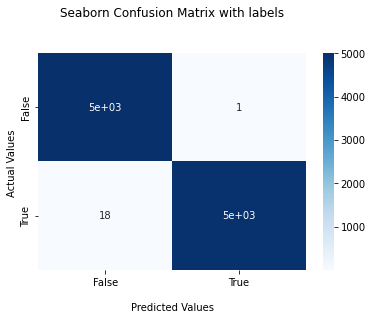

In [ ]:
labels = np.array([])
pred = np.array([])
for x, y in val_dataset:
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])
  pred = np.concatenate([pred, np.argmax(net_norm_reg_l2_20.predict(x), axis=-1)])


fpr, tpr, _ = roc_curve(labels, pred)
print(f'Sensitivity: {tpr[1]}')
cf_matrix = confusion_matrix(labels, pred)
grafico(cf_matrix, 'net_norm_reg_l2_20.png')

## **dropout**

### **Architecture Definition**


In [ ]:
# Architecture definition v1
inputs = keras.Input((227,227,3)) #raw,columns,channels(RGB)

x = inputs
x = keras.layers.Conv2D(8, 3, padding="same")(x) #32 filters 3x3, "same" chose automatically the padding dimension
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x) #activation function is ReLU
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x) #filter dimension = 3, stripe = 3
x = keras.layers.Dropout(0.3)(x)

x = keras.layers.Conv2D(16, 3, padding="same")(x) #altro layer convoluzionale
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x) #filter dimension = 3, stripe = 3
x = keras.layers.Dropout(0.3)(x)

x = keras.layers.Conv2D(16, 3, padding="same")(x) #altro layer convoluzionale
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x) #filter dimension = 3, stripe = 3
x = keras.layers.Dropout(0.3)(x)

x = keras.layers.Conv2D(32, 3, padding="same")(x) #altro layer convoluzionale
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x) #filter dimension = 3, stripe = 3
x = keras.layers.Dropout(0.3)(x)

x = keras.layers.Conv2D(32, 3, padding="same")(x) #altro layer convoluzionale
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)

x = keras.layers.GlobalMaxPooling2D()(x)

outputs = keras.layers.Dense(num_classes, activation="softmax")(x) #output layer, we use softmax cause is the common one
net_norm_reg_dropout_20 = keras.Model(inputs, outputs) #construction of the model


# Compile the model for training
net_norm_reg_dropout_20.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy'])


# Model training (v1)
history_norm_reg_dropout_20 = net_norm_reg_dropout_20.fit(train_dataset,
          epochs=20,
          validation_data=val_dataset);

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 1/20
1438/1438 [==============================] - 113s 77ms/step - loss: 0.0543 - accuracy: 0.9815 - val_loss: 0.3526 - val_accuracy: 0.8805
Epoch 2/20
1438/1438 [==============================] - 94s 65ms/step - loss: 0.0262 - accuracy: 0.9918 - val_loss: 0.2037 - val_accuracy: 0.9313
Epoch 3/20
1438/1438 [==============================] - 99s 68ms/step - loss: 0.0200 - accuracy: 0.9942 - val_loss: 0.1244 - val_accuracy: 0.9564
Epoch 4/20
1438/1438 [==============================] - 102s 70ms/step - loss: 0.0172 - accuracy: 0.9944 - val_loss: 0.0962 - val_accuracy: 0.9676
Epoch 5/20
1438/1438 [==============================] - 93s 65ms/step - loss: 0.0150 - accuracy: 0.9953 - val_loss: 0.0831 - val_accuracy: 0.9721
Epoch 6/20
1438/1438 [==============================] - 92s 63ms/step - loss: 0.0148 - accuracy: 0.9957 - val_loss: 0.0582 - val_accuracy: 0.9804
Epoch 7/20
1438/1438 [==============================] - 95s 66ms/step - loss: 0.0141 - accuracy: 0.9958 - val_loss: 0.0454

### **Saving of the History in Google Drive**


In [ ]:
name='net_norm_reg_dropout_20_1_new_data'
joblib.dump(net_norm_reg_dropout_20, f'{name}.sav')
np.save(f'{name}_history.npy',history_norm_reg_dropout_20)
copyfile(f'{name}.sav', f'gdrive/My Drive/FDL_project/saves/{name}.sav')
copyfile(f'{name}_history.npy', f'gdrive/My Drive/FDL_project/saves/{name}_history.npy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

INFO:tensorflow:Assets written to: ram://71cbd05c-1a8c-437c-9c95-fce1eea91eff/assets
INFO:tensorflow:Assets written to: ram://28b393bf-a204-4102-a621-44f18fd79451/assets


'gdrive/My Drive/FDL_project/saves/net_norm_reg_dropout_20_1_new_data_history.npy'

### **Confusion Matrix**


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Sensitivity: 0.9807538091419407


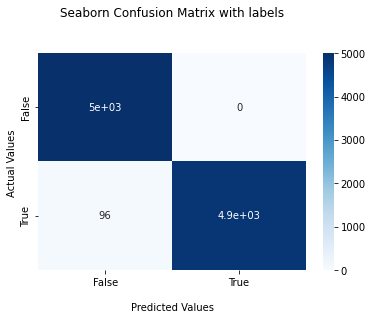

In [ ]:
labels = np.array([])
pred = np.array([])
for x, y in val_dataset:
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])
  pred = np.concatenate([pred, np.argmax(net_norm_reg_dropout_20.predict(x), axis=-1)])


fpr, tpr, _ = roc_curve(labels, pred)
print(f'Sensitivity: {tpr[1]}')
cf_matrix = confusion_matrix(labels, pred)
grafico(cf_matrix, 'net_norm_reg_dropout_20.png')

## **Visualization of the learning curves**

### **Loss**

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

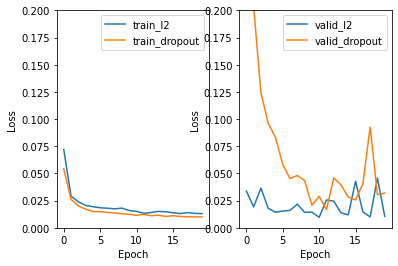

In [ ]:
#Plot the loss
plt.subplot(1, 2, 1)
plt.plot(history_norm_reg_l2_20.history['loss'])
plt.plot(history_norm_reg_dropout_20.history['loss'])
plt.ylim([0.0, 0.2])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train_l2', 'train_dropout' ])

plt.subplot(1, 2, 2)
plt.plot(history_norm_reg_l2_20.history['val_loss'])
plt.plot(history_norm_reg_dropout_20.history['val_loss'])
plt.ylim([0.0, 0.2])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['valid_l2' ,'valid_dropout' ])
plt.savefig('reg_loss.png')

### **Accuracy**

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

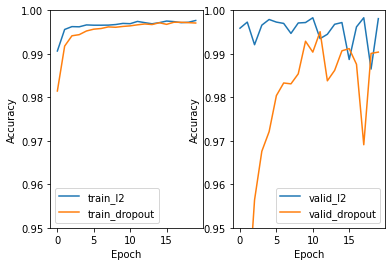

In [ ]:
#plot the accuracy
plt.subplot(1, 2, 1)
plt.plot(history_norm_reg_l2_20.history['accuracy'])
plt.plot(history_norm_reg_dropout_20.history['accuracy'])
plt.ylim([0.95, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train_l2' ,'train_dropout' ])

plt.subplot(1, 2, 2)
plt.plot(history_norm_reg_l2_20.history['val_accuracy'])
plt.plot(history_norm_reg_dropout_20.history['val_accuracy'])
plt.ylim([0.95, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['valid_l2', 'valid_dropout' ])
plt.savefig('reg_accuracy.png')

# **LOSS FUNCTION**

## **Architecture Definition**


In [ ]:
# Architecture definition v1
inputs = keras.Input((227,227,3)) #raw,columns,channels(RGB)

x = inputs
x = keras.layers.Conv2D(8, 3, padding="same")(x) #32 filters 3x3, "same" chose automatically the padding dimension
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x) #activation function is ReLU
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x) #filter dimension = 3, stripe = 3

x = keras.layers.Conv2D(16, 3, padding="same")(x) #altro layer convoluzionale
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x) #filter dimension = 3, stripe = 3

x = keras.layers.Conv2D(16, 3, padding="same")(x) #altro layer convoluzionale
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x) #filter dimension = 3, stripe = 3

x = keras.layers.Conv2D(32, 3, padding="same")(x) #altro layer convoluzionale
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x) #filter dimension = 3, stripe = 3

x = keras.layers.Conv2D(32, 3, padding="same")(x) #altro layer convoluzionale
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)

x = keras.layers.GlobalMaxPooling2D()(x)

outputs = keras.layers.Dense(num_classes, activation="softmax")(x) #output layer, we use softmax cause is the common one
net_binary_crossentropy = keras.Model(inputs, outputs) #construction of the model


# Compile the model for training
net_binary_crossentropy.compile(loss=keras.losses.BinaryCrossentropy(reduction='sum'),
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy'])


# Model training (v1)
history_binary_crossentropy = net_binary_crossentropy.fit(train_dataset,
          epochs=10,
          validation_data=val_dataset);

<IPython.core.display.Javascript object>

Epoch 1/10
1750/1750 [==============================] - 82s 45ms/step - loss: 0.7392 - accuracy: 0.9929 - val_loss: 0.2484 - val_accuracy: 0.9981
Epoch 2/10
1750/1750 [==============================] - 109s 62ms/step - loss: 0.3329 - accuracy: 0.9967 - val_loss: 0.2070 - val_accuracy: 0.9982
Epoch 3/10
1750/1750 [==============================] - 83s 48ms/step - loss: 0.2530 - accuracy: 0.9978 - val_loss: 0.1671 - val_accuracy: 0.9991
Epoch 4/10
1750/1750 [==============================] - 76s 43ms/step - loss: 0.1995 - accuracy: 0.9983 - val_loss: 0.1783 - val_accuracy: 0.9991
Epoch 5/10
1750/1750 [==============================] - 76s 43ms/step - loss: 0.1830 - accuracy: 0.9984 - val_loss: 0.1786 - val_accuracy: 0.9992
Epoch 6/10
1750/1750 [==============================] - 78s 44ms/step - loss: 0.1357 - accuracy: 0.9989 - val_loss: 0.2401 - val_accuracy: 0.9983
Epoch 7/10
1750/1750 [==============================] - 76s 43ms/step - loss: 0.1400 - accuracy: 0.9988 - val_loss: 0.4326 

## **Saving of the History in Google Drive**


In [ ]:
name='net_binary_crossentropy_1_new_data'
joblib.dump(net_binary_crossentropy, f'{name}.sav')
np.save(f'{name}_history.npy',history_binary_crossentropy)
copyfile(f'{name}.sav', f'gdrive/My Drive/FDL_project/saves/{name}.sav')
copyfile(f'{name}_history.npy', f'gdrive/My Drive/FDL_project/saves/{name}_history.npy')

<IPython.core.display.Javascript object>

INFO:tensorflow:Assets written to: ram://4f4dfde3-32e8-4d0c-894e-f6d7eb28fdfd/assets
INFO:tensorflow:Assets written to: ram://90946692-4ab8-4c32-bd50-1a64c769e1cc/assets


'gdrive/My Drive/FDL_project/saves/net_binary_crossentropy_1_new_data_history.npy'

 ## **Confusion Matrix**


<IPython.core.display.Javascript object>

Sensitivity: 0.9984


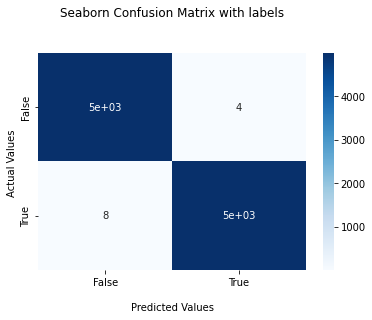

In [ ]:
labels = np.array([])
pred = np.array([])
for x, y in val_dataset:
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])
  pred = np.concatenate([pred, np.argmax(net_binary_crossentropy.predict(x), axis=-1)])


fpr, tpr, _ = roc_curve(labels, pred)
print(f'Sensitivity: {tpr[1]}')
cf_matrix = confusion_matrix(labels, pred)
grafico(cf_matrix, 'net_binary_crossentropy.png')

## **Visualization of the learning curves**


### **Accuracy**


<IPython.core.display.Javascript object>

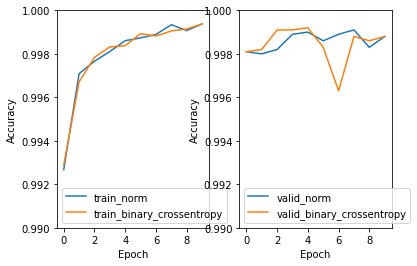

In [ ]:
#plot the accuracy
plt.subplot(1, 2, 1)
plt.plot(history_norm.history['accuracy'])
plt.plot(history_binary_crossentropy.history['accuracy'])
plt.ylim([0.99, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train_norm', 'train_binary_crossentropy' ])

plt.subplot(1, 2, 2)
plt.plot(history_norm.history['val_accuracy'])
plt.plot(history_binary_crossentropy.history['val_accuracy'])
plt.ylim([0.99, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['valid_norm','valid_binary_crossentropy' ])
plt.savefig('binary_crossentropy_accuracy.png')

### **Visualization of the learning curves**


#### **Loss**


<IPython.core.display.Javascript object>

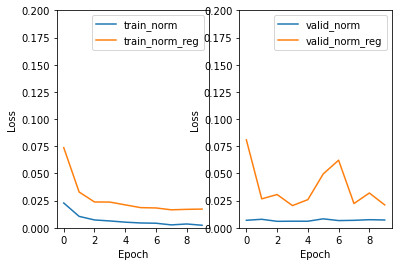

In [ ]:
#Plot the loss
plt.subplot(1, 2, 1)
plt.plot(history_norm.history['loss'])
plt.plot(history_norm_reg.history['loss'])
plt.ylim([0.0, 0.2])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train_norm', 'train_norm_reg' ])

plt.subplot(1, 2, 2)
plt.plot(history_norm.history['val_loss'])
plt.plot(history_norm_reg.history['val_loss'])
plt.ylim([0.0, 0.2])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['valid_norm','valid_norm_reg' ])
plt.savefig('norm_reg_loss.png')

#### **Accuracy**


<IPython.core.display.Javascript object>

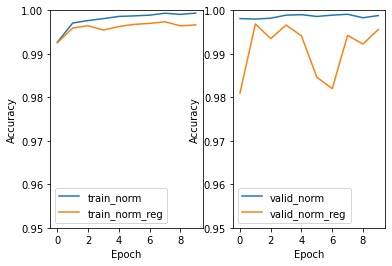

In [ ]:
#plot the accuracy
plt.subplot(1, 2, 1)
plt.plot(history_norm.history['accuracy'])
plt.plot(history_norm_reg.history['accuracy'])
plt.ylim([0.95, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train_norm', 'train_norm_reg' ])

plt.subplot(1, 2, 2)
plt.plot(history_norm.history['val_accuracy'])
plt.plot(history_norm_reg.history['val_accuracy'])
plt.ylim([0.95, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['valid_norm','valid_norm_reg' ])
plt.savefig('norm_reg_accuracy.png')

# **OPTIMIZER**

##**SGD**

### **Architecture Definition**


In [ ]:
# Architecture definition v1
inputs = keras.Input((227,227,3)) #raw,columns,channels(RGB)

x = inputs
x = keras.layers.Conv2D(8, 3, padding="same")(x) #32 filters 3x3, "same" chose automatically the padding dimension
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x) #activation function is ReLU
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x) #filter dimension = 3, stripe = 3

x = keras.layers.Conv2D(16, 3, padding="same")(x) #altro layer convoluzionale
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x) #filter dimension = 3, stripe = 3

x = keras.layers.Conv2D(16, 3, padding="same")(x) #altro layer convoluzionale
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x) #filter dimension = 3, stripe = 3

x = keras.layers.Conv2D(32, 3, padding="same")(x) #altro layer convoluzionale
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x) #filter dimension = 3, stripe = 3

x = keras.layers.Conv2D(32, 3, padding="same")(x) #altro layer convoluzionale
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)

x = keras.layers.GlobalMaxPooling2D()(x)

outputs = keras.layers.Dense(num_classes, activation="softmax")(x) #output layer, we use softmax cause is the common one
net_optim = keras.Model(inputs, outputs) #construction of the model

# Compile the model for training
net_optim.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=False, name="SGD"),
            metrics=['accuracy'])


# Model training (v1)
history_optim = net_optim.fit(train_dataset,
          epochs=10,
          validation_data=val_dataset);

### **Saving of the History in Google Drive**


In [ ]:

name='net_optim_1_new_data'
joblib.dump(net_optim, f'{name}.sav')
np.save(f'{name}_history.npy',history_optim)
copyfile(f'{name}.sav', f'gdrive/My Drive/FDL_project/saves/{name}.sav')
copyfile(f'{name}_history.npy', f'gdrive/My Drive/FDL_project/saves/{name}_history.npy')




 ### **Confusion Matrix**


<IPython.core.display.Javascript object>

Sensitivity: 0.998


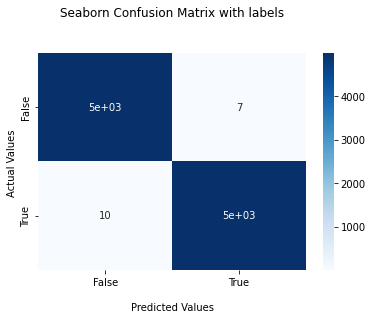

In [ ]:
labels = np.array([])
pred = np.array([])
for x, y in val_dataset:
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])
  pred = np.concatenate([pred, np.argmax(net_optim.predict(x), axis=-1)])


fpr, tpr, _ = roc_curve(labels, pred)
print(f'Sensitivity: {tpr[1]}')
cf_matrix = confusion_matrix(labels, pred)
grafico(cf_matrix, 'net_optim.png')

##**ADAM**

### **Architecture Definition**


In [ ]:
# Architecture definition v1
inputs = keras.Input((227,227,3)) #raw,columns,channels(RGB)

x = inputs
x = keras.layers.Conv2D(8, 3, padding="same")(x) #32 filters 3x3, "same" chose automatically the padding dimension
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x) #activation function is ReLU
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x) #filter dimension = 3, stripe = 3

x = keras.layers.Conv2D(16, 3, padding="same")(x) #altro layer convoluzionale
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x) #filter dimension = 3, stripe = 3

x = keras.layers.Conv2D(16, 3, padding="same")(x) #altro layer convoluzionale
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x) #filter dimension = 3, stripe = 3

x = keras.layers.Conv2D(32, 3, padding="same")(x) #altro layer convoluzionale
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x) #filter dimension = 3, stripe = 3

x = keras.layers.Conv2D(32, 3, padding="same")(x) #altro layer convoluzionale
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)

x = keras.layers.GlobalMaxPooling2D()(x)

outputs = keras.layers.Dense(num_classes, activation="softmax")(x) #output layer, we use softmax cause is the common one
net_optim_adam = keras.Model(inputs, outputs) #construction of the model


# Compile the model for training
net_optim_adam.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
            metrics=['accuracy'])


# Model training (v1)
history_optim_adam = net_optim_adam.fit(train_dataset,
          epochs=10,
          validation_data=val_dataset);

<IPython.core.display.Javascript object>

Epoch 1/10
1750/1750 [==============================] - 85s 48ms/step - loss: 0.0277 - accuracy: 0.9911 - val_loss: 0.0087 - val_accuracy: 0.9984
Epoch 2/10
1750/1750 [==============================] - 76s 43ms/step - loss: 0.0135 - accuracy: 0.9959 - val_loss: 0.0173 - val_accuracy: 0.9962
Epoch 3/10
1750/1750 [==============================] - 76s 43ms/step - loss: 0.0106 - accuracy: 0.9967 - val_loss: 0.0092 - val_accuracy: 0.9985
Epoch 4/10
1750/1750 [==============================] - 78s 44ms/step - loss: 0.0095 - accuracy: 0.9971 - val_loss: 0.0110 - val_accuracy: 0.9977
Epoch 5/10
1750/1750 [==============================] - 76s 43ms/step - loss: 0.0088 - accuracy: 0.9974 - val_loss: 0.0111 - val_accuracy: 0.9977
Epoch 6/10
1750/1750 [==============================] - 76s 43ms/step - loss: 0.0076 - accuracy: 0.9978 - val_loss: 0.0074 - val_accuracy: 0.9990
Epoch 7/10
1750/1750 [==============================] - 78s 44ms/step - loss: 0.0066 - accuracy: 0.9981 - val_loss: 0.0100 -

### **Saving of the History in Google Drive**


In [ ]:
name='net_optim_adam_1_new_data'
joblib.dump(net_optim_adam, f'{name}.sav')
np.save(f'{name}_history.npy',history_optim_adam)
copyfile(f'{name}.sav', f'gdrive/My Drive/FDL_project/saves/{name}.sav')
copyfile(f'{name}_history.npy', f'gdrive/My Drive/FDL_project/saves/{name}_history.npy')

<IPython.core.display.Javascript object>

INFO:tensorflow:Assets written to: ram://e35f290c-d91d-460a-acc2-97a2d40d2e9d/assets
INFO:tensorflow:Assets written to: ram://5c609691-72c5-4f37-b75f-6ff1e234efd7/assets


'gdrive/My Drive/FDL_project/saves/net_optim_adam_1_new_data_history.npy'

 ### **Confusion Matrix**


<IPython.core.display.Javascript object>

Sensitivity: 0.9992


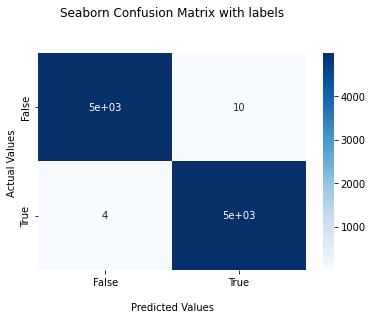

In [ ]:
labels = np.array([])
pred = np.array([])
for x, y in val_dataset:
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])
  pred = np.concatenate([pred, np.argmax(net_optim_adam.predict(x), axis=-1)])

fpr, tpr, _ = roc_curve(labels, pred)
print(f'Sensitivity: {tpr[1]}')
cf_matrix = confusion_matrix(labels, pred)
grafico(cf_matrix, 'net_optim_adam.png')

### **Visualization of the learning curves**


#### **Loss**


<IPython.core.display.Javascript object>

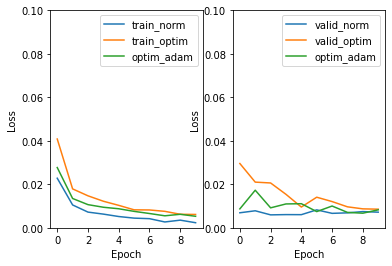

In [ ]:
#Plot the loss
plt.subplot(1, 2, 1)
plt.plot(history_norm.history['loss'])
plt.plot(history_optim.history['loss'])
plt.plot(history_optim_adam.history['loss'])
plt.ylim([0.0, 0.1])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train_norm', 'train_optim','optim_adam' ])

plt.subplot(1, 2, 2)
plt.plot(history_norm.history['val_loss'])
plt.plot(history_optim.history['val_loss'])
plt.plot(history_optim_adam.history['val_loss'])
plt.ylim([0.0, 0.1])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['valid_norm','valid_optim','optim_adam' ])
plt.savefig('optim_loss.png')

#### **Accuracy**


<IPython.core.display.Javascript object>

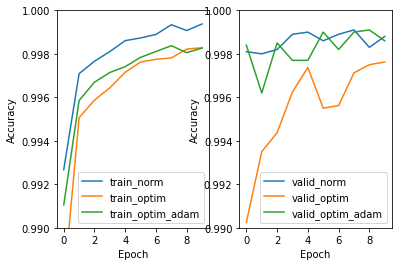

In [ ]:
#plot the accuracy
plt.subplot(1, 2, 1)
plt.plot(history_norm.history['accuracy'])
plt.plot(history_optim.history['accuracy'])
plt.plot(history_optim_adam.history['accuracy'])
plt.ylim([0.99, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train_norm', 'train_optim','train_optim_adam' ])

plt.subplot(1, 2, 2)
plt.plot(history_norm.history['val_accuracy'])
plt.plot(history_optim.history['val_accuracy'])
plt.plot(history_optim_adam.history['val_accuracy'])
plt.ylim([0.99, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['valid_norm','valid_optim','valid_optim_adam' ])
plt.savefig('optim_accuracy.png')

Scegliamo la norm semplice (con RMSprop) anche se la sensitivity è leggermente migliorei in quella con optimizer ADAM.



# **STRIDE**

##**stride = 2**

### **Architecture Definition**


In [ ]:
# Architecture definition v1
inputs = keras.Input((227,227,3)) #raw,columns,channels(RGB)

x = inputs
x = keras.layers.Conv2D(8, 3, padding="same")(x) #32 filters 3x3, "same" chose automatically the padding dimension
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x) #activation function is ReLU
x = keras.layers.MaxPooling2D(3, strides=2, padding="same")(x) #filter dimension = 3, stripe = 3

x = keras.layers.Conv2D(16, 3, padding="same")(x) #altro layer convoluzionale
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=2, padding="same")(x) #filter dimension = 3, stripe = 3

x = keras.layers.Conv2D(16, 3, padding="same")(x) #altro layer convoluzionale
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=2, padding="same")(x) #filter dimension = 3, stripe = 3

x = keras.layers.Conv2D(32, 3, padding="same")(x) #altro layer convoluzionale
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=2, padding="same")(x) #filter dimension = 3, stripe = 3

x = keras.layers.Conv2D(32, 3, padding="same")(x) #altro layer convoluzionale
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)

x = keras.layers.GlobalMaxPooling2D()(x)

outputs = keras.layers.Dense(num_classes, activation="softmax")(x) #output layer, we use softmax cause is the common one
net_norm_s2 = keras.Model(inputs, outputs) #construction of the model


# Compile the model for training
net_norm_s2.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy'])


# Model training (v1)
history_norm_s2 = net_norm_s2.fit(train_dataset,
          epochs=10,
          validation_data=val_dataset);

<IPython.core.display.Javascript object>

Epoch 1/10
1750/1750 [==============================] - 114s 63ms/step - loss: 0.0220 - accuracy: 0.9927 - val_loss: 0.0113 - val_accuracy: 0.9962
Epoch 2/10
1750/1750 [==============================] - 114s 65ms/step - loss: 0.0109 - accuracy: 0.9967 - val_loss: 0.0063 - val_accuracy: 0.9984
Epoch 3/10
1750/1750 [==============================] - 85s 48ms/step - loss: 0.0079 - accuracy: 0.9976 - val_loss: 0.0063 - val_accuracy: 0.9984
Epoch 4/10
1750/1750 [==============================] - 109s 62ms/step - loss: 0.0073 - accuracy: 0.9977 - val_loss: 0.0090 - val_accuracy: 0.9971
Epoch 5/10
1750/1750 [==============================] - 115s 66ms/step - loss: 0.0062 - accuracy: 0.9982 - val_loss: 0.0072 - val_accuracy: 0.9980
Epoch 6/10
1750/1750 [==============================] - 111s 64ms/step - loss: 0.0055 - accuracy: 0.9984 - val_loss: 0.0099 - val_accuracy: 0.9972
Epoch 7/10
1750/1750 [==============================] - 114s 65ms/step - loss: 0.0049 - accuracy: 0.9986 - val_loss: 0.

### **Saving of the History in Google Drive**


In [ ]:
name='net_norm_s2_1_new_data'
joblib.dump(net_norm_s2, f'{name}.sav')
np.save(f'{name}_history.npy',history_norm_s2)
copyfile(f'{name}.sav', f'gdrive/My Drive/FDL_project/saves/{name}.sav')
copyfile(f'{name}_history.npy', f'gdrive/My Drive/FDL_project/saves/{name}_history.npy')

<IPython.core.display.Javascript object>

INFO:tensorflow:Assets written to: ram://56331401-f835-4cb1-8973-847c1a2b8e18/assets
INFO:tensorflow:Assets written to: ram://9c0397d9-74fa-4e16-9607-639ccd2c5477/assets


'gdrive/My Drive/FDL_project/saves/net_norm_s2_1_new_data_history.npy'

 ### **Confusion Matrix**


<IPython.core.display.Javascript object>

Sensitivity: 0.9982


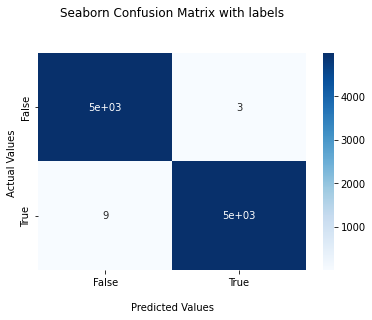

In [ ]:
labels = np.array([])
pred = np.array([])
for x, y in val_dataset:
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])
  pred = np.concatenate([pred, np.argmax(net_norm_s2.predict(x), axis=-1)])


fpr, tpr, _ = roc_curve(labels, pred)
print(f'Sensitivity: {tpr[1]}')
cf_matrix = confusion_matrix(labels, pred)
grafico(cf_matrix, 'net_norm_s2.png')

##**stride = 4**

### **Architecture Definition**


In [ ]:
inputs = keras.Input((227,227,3))

x = inputs
x = keras.layers.Conv2D(8, 3, padding="same")(x) 
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x) 
x = keras.layers.MaxPooling2D(3, strides=4, padding="same")(x) 

x = keras.layers.Conv2D(16, 3, padding="same")(x) 
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=4, padding="same")(x) 

x = keras.layers.Conv2D(16, 3, padding="same")(x) 
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=4, padding="same")(x) 

x = keras.layers.Conv2D(32, 3, padding="same")(x) 
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=4, padding="same")(x) 

x = keras.layers.Conv2D(32, 3, padding="same")(x) 
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)

x = keras.layers.GlobalMaxPooling2D()(x)

outputs = keras.layers.Dense(num_classes, activation="softmax")(x)
net_norm_s4 = keras.Model(inputs, outputs) 



net_norm_s4.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy'])



history_norm_s4 = net_norm_s4.fit(train_dataset,
          epochs=10,
          validation_data=val_dataset);

### **Saving of the History in Google Drive**


In [ ]:
name='net_norm_s4_1_new_data'
joblib.dump(net_norm_s4, f'{name}.sav')
np.save(f'{name}_history.npy',history_norm_s4)
copyfile(f'{name}.sav', f'gdrive/My Drive/FDL_project/saves/{name}.sav')
copyfile(f'{name}_history.npy', f'gdrive/My Drive/FDL_project/saves/{name}_history.npy')

 ### **Confusion Matrix**


<IPython.core.display.Javascript object>

Sensitivity: 0.9994


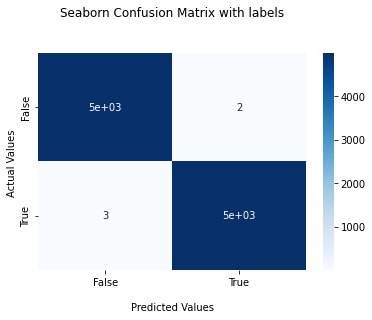

In [ ]:
labels = np.array([])
pred = np.array([])
for x, y in val_dataset:
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])
  pred = np.concatenate([pred, np.argmax(net_norm_s4.predict(x), axis=-1)])


fpr, tpr, _ = roc_curve(labels, pred)
print(f'Sensitivity: {tpr[1]}')
cf_matrix = confusion_matrix(labels, pred)
grafico(cf_matrix, 'net_norm_s4.png')

##**stride = 5**

### **Architecture Definition**


In [ ]:
inputs = keras.Input((227,227,3))

x = inputs
x = keras.layers.Conv2D(8, 3, padding="same")(x) 
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x) 
x = keras.layers.MaxPooling2D(3, strides=5, padding="same")(x) 

x = keras.layers.Conv2D(16, 3, padding="same")(x) 
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=5, padding="same")(x) 

x = keras.layers.Conv2D(16, 3, padding="same")(x) 
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=5, padding="same")(x) 

x = keras.layers.Conv2D(32, 3, padding="same")(x) 
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=5, padding="same")(x) 

x = keras.layers.Conv2D(32, 3, padding="same")(x) 
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)

x = keras.layers.GlobalMaxPooling2D()(x)

outputs = keras.layers.Dense(num_classes, activation="softmax")(x)
net_norm_s5 = keras.Model(inputs, outputs) 



net_norm_s5.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy'])



history_norm_s5 = net_norm_s5.fit(train_dataset,
          epochs=10,
          validation_data=val_dataset);

<IPython.core.display.Javascript object>

Epoch 1/10
1750/1750 [==============================] - 118s 66ms/step - loss: 0.0392 - accuracy: 0.9879 - val_loss: 0.0158 - val_accuracy: 0.9954
Epoch 2/10
1750/1750 [==============================] - 114s 65ms/step - loss: 0.0223 - accuracy: 0.9936 - val_loss: 0.0113 - val_accuracy: 0.9970
Epoch 3/10
1750/1750 [==============================] - 110s 63ms/step - loss: 0.0188 - accuracy: 0.9944 - val_loss: 0.0140 - val_accuracy: 0.9953
Epoch 4/10
1750/1750 [==============================] - 109s 62ms/step - loss: 0.0175 - accuracy: 0.9950 - val_loss: 0.0101 - val_accuracy: 0.9968
Epoch 5/10
1750/1750 [==============================] - 112s 64ms/step - loss: 0.0140 - accuracy: 0.9962 - val_loss: 0.0120 - val_accuracy: 0.9973
Epoch 6/10
1750/1750 [==============================] - 104s 59ms/step - loss: 0.0146 - accuracy: 0.9959 - val_loss: 0.0124 - val_accuracy: 0.9970
Epoch 7/10
1750/1750 [==============================] - 76s 43ms/step - loss: 0.0133 - accuracy: 0.9963 - val_loss: 0.

### **Saving of the History in Google Drive**


In [ ]:
name='net_norm_s5_1_new_data'
joblib.dump(net_norm_s5, f'{name}.sav')
np.save(f'{name}_history.npy',history_norm_s5)
copyfile(f'{name}.sav', f'gdrive/My Drive/FDL_project/saves/{name}.sav')
copyfile(f'{name}_history.npy', f'gdrive/My Drive/FDL_project/saves/{name}_history.npy')

<IPython.core.display.Javascript object>

INFO:tensorflow:Assets written to: ram://1c7c237a-e01d-4485-8846-ab80cb4bdcce/assets
INFO:tensorflow:Assets written to: ram://1108d2ea-3435-456d-b33e-87ea7af37259/assets


'gdrive/My Drive/FDL_project/saves/net_norm_s5_1_new_data_history.npy'

 ### **Confusion Matrix**


<IPython.core.display.Javascript object>

Sensitivity: 0.9956


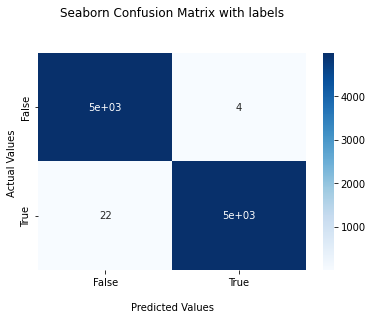

In [ ]:
labels = np.array([])
pred = np.array([])
for x, y in val_dataset:
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])
  pred = np.concatenate([pred, np.argmax(net_norm_s5.predict(x), axis=-1)])


fpr, tpr, _ = roc_curve(labels, pred)
print(f'Sensitivity: {tpr[1]}')
cf_matrix = confusion_matrix(labels, pred)
grafico(cf_matrix, 'net_norm_s5.png')

## **Visualization of the learning curves**

### **Loss**

<IPython.core.display.Javascript object>

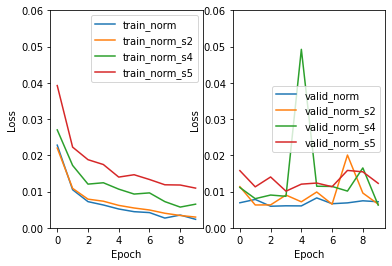

In [ ]:
#Plot the loss
plt.subplot(1, 2, 1)
plt.plot(history_norm.history['loss'])
plt.plot(history_norm_s2.history['loss'])
plt.plot(history_norm_s4.history['loss'])
plt.plot(history_norm_s5.history['loss'])
plt.ylim([0.0, 0.06])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train_norm', 'train_norm_s2','train_norm_s4' ,'train_norm_s5' ])

plt.subplot(1, 2, 2)
plt.plot(history_norm.history['val_loss'])
plt.plot(history_norm_s2.history['val_loss'])
plt.plot(history_norm_s4.history['val_loss'])
plt.plot(history_norm_s5.history['val_loss'])
plt.ylim([0.0, 0.06])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['valid_norm','valid_norm_s2','valid_norm_s4' ,'valid_norm_s5' ])
plt.savefig('stripe_loss.png')

### **Accuracy**

<IPython.core.display.Javascript object>

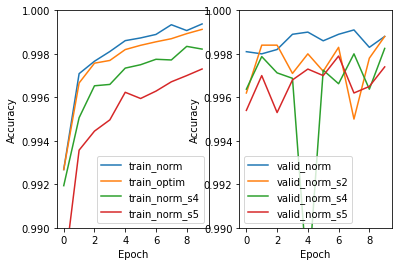

In [ ]:
#plot the accuracy
plt.subplot(1, 2, 1)
plt.plot(history_norm.history['accuracy'])
plt.plot(history_norm_s2.history['accuracy'])
plt.plot(history_norm_s4.history['accuracy'])
plt.plot(history_norm_s5.history['accuracy'])
plt.ylim([0.99, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train_norm', 'train_optim','train_norm_s4','train_norm_s5' ])

plt.subplot(1, 2, 2)
plt.plot(history_norm.history['val_accuracy'])
plt.plot(history_norm_s2.history['val_accuracy'])
plt.plot(history_norm_s4.history['val_accuracy'])
plt.plot(history_norm_s5.history['val_accuracy'])
plt.ylim([0.99, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['valid_norm','valid_norm_s2','valid_norm_s4' ,'valid_norm_s5' ])
plt.savefig('stripe_accuracy.png')

## **stride = 4 + fc**

### **Architecture Definition**


In [ ]:
inputs = keras.Input((227,227,3))

x = inputs
x = keras.layers.Conv2D(8, 3, padding="same")(x) 
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x) 
x = keras.layers.MaxPooling2D(3, strides=4, padding="same")(x) 

x = keras.layers.Conv2D(16, 3, padding="same")(x) 
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=4, padding="same")(x) 

x = keras.layers.Conv2D(16, 3, padding="same")(x) 
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=4, padding="same")(x) 

x = keras.layers.Conv2D(32, 3, padding="same")(x) 
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=4, padding="same")(x) 

x = keras.layers.Conv2D(32, 3, padding="same")(x) 
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)

x = keras.layers.GlobalMaxPooling2D()(x)

x = keras.layers.Dense(16, activation="relu")(x) #FULLY COONNECTED LAYER

outputs = keras.layers.Dense(num_classes, activation="softmax")(x)
net_norm_s4_fc = keras.Model(inputs, outputs) 



net_norm_s4_fc.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy'])



history_norm_s4_fc = net_norm_s4_fc.fit(train_dataset,
          epochs=10,
          validation_data=val_dataset);

<IPython.core.display.Javascript object>

Epoch 1/10
1438/1438 [==============================] - 121s 72ms/step - loss: 0.0388 - accuracy: 0.9892 - val_loss: 0.0186 - val_accuracy: 0.9941
Epoch 2/10
1438/1438 [==============================] - 108s 75ms/step - loss: 0.0197 - accuracy: 0.9950 - val_loss: 0.0272 - val_accuracy: 0.9919
Epoch 3/10
1438/1438 [==============================] - 89s 62ms/step - loss: 0.0183 - accuracy: 0.9952 - val_loss: 0.0113 - val_accuracy: 0.9964
Epoch 4/10
1438/1438 [==============================] - 83s 57ms/step - loss: 0.0154 - accuracy: 0.9959 - val_loss: 0.0169 - val_accuracy: 0.9955
Epoch 5/10
1438/1438 [==============================] - 63s 44ms/step - loss: 0.0125 - accuracy: 0.9964 - val_loss: 0.0086 - val_accuracy: 0.9973
Epoch 6/10
1438/1438 [==============================] - 62s 43ms/step - loss: 0.0115 - accuracy: 0.9970 - val_loss: 0.0266 - val_accuracy: 0.9943
Epoch 7/10
1438/1438 [==============================] - 61s 43ms/step - loss: 0.0118 - accuracy: 0.9971 - val_loss: 0.0104

### **Saving of the History in Google Drive**


In [ ]:
name='net_norm_s4_fc_1_new_data'
joblib.dump(net_norm_s4_fc, f'{name}.sav')
np.save(f'{name}_history.npy',history_norm_s4_fc)
copyfile(f'{name}.sav', f'gdrive/My Drive/FDL_project/saves/{name}.sav')
copyfile(f'{name}_history.npy', f'gdrive/My Drive/FDL_project/saves/{name}_history.npy')

<IPython.core.display.Javascript object>

INFO:tensorflow:Assets written to: ram://543a4f53-e851-46dc-822e-c257072c1113/assets
INFO:tensorflow:Assets written to: ram://c66fda8a-8690-4069-ad6e-1bddc735bc7e/assets


'gdrive/My Drive/FDL_project/saves/net_norm_s4_fc_1_new_data_history.npy'

 ### **Confusion Matrix**


<IPython.core.display.Javascript object>

Sensitivity: 0.9985966319165999


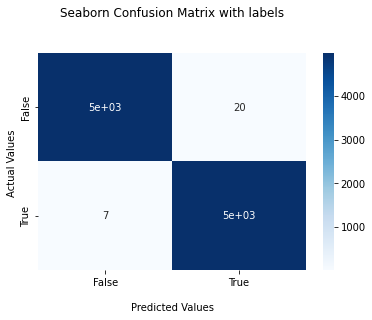

In [ ]:
labels = np.array([])
pred = np.array([])
for x, y in val_dataset:
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])
  pred = np.concatenate([pred, np.argmax(net_norm_s4_fc.predict(x), axis=-1)])


fpr, tpr, _ = roc_curve(labels, pred)
print(f'Sensitivity: {tpr[1]}')
cf_matrix = confusion_matrix(labels, pred)
grafico(cf_matrix, 'net_norm_s4_fc.png')


### **plot loss**

<IPython.core.display.Javascript object>

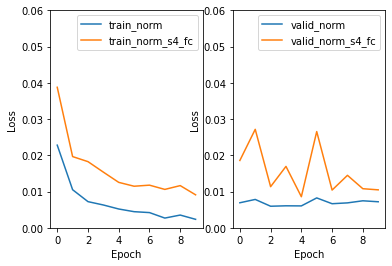

In [ ]:
#Plot the loss
plt.subplot(1, 2, 1)
plt.plot(history_norm.history['loss'])
plt.plot(history_norm_s4_fc.history['loss'])
plt.ylim([0.0, 0.06])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train_norm', 'train_norm_s4_fc'])

plt.subplot(1, 2, 2)
plt.plot(history_norm.history['val_loss'])
plt.plot(history_norm_s4_fc.history['val_loss'])
plt.ylim([0.0, 0.06])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['valid_norm','valid_norm_s4_fc' ])
plt.savefig('stripe_4_fc_loss.png')

###**plot accuracy**

<IPython.core.display.Javascript object>

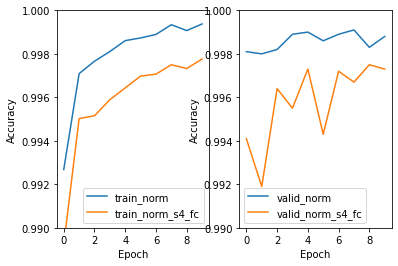

In [ ]:
#plot the accuracy
plt.subplot(1, 2, 1)
plt.plot(history_norm.history['accuracy'])
plt.plot(history_norm_s4_fc.history['accuracy'])
plt.ylim([0.99, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train_norm', 'train_norm_s4_fc' ])

plt.subplot(1, 2, 2)
plt.plot(history_norm.history['val_accuracy'])
plt.plot(history_norm_s4_fc.history['val_accuracy'])
plt.ylim([0.99, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['valid_norm','valid_norm_s4_fc'])
plt.savefig('stripe_4_fc_accuracy.png')

# **FULLY CONNECTED LAYER**

## **Architecture Definition**


In [ ]:
# Architecture definition v1
inputs = keras.Input((227,227,3)) #raw,columns,channels(RGB)

x = inputs
x = keras.layers.Conv2D(8, 3, padding="same")(x) #32 filters 3x3, "same" chose automatically the padding dimension
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x) #activation function is ReLU
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x) #filter dimension = 3, stripe = 3

x = keras.layers.Conv2D(16, 3, padding="same")(x) #altro layer convoluzionale
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x) #filter dimension = 3, stripe = 3

x = keras.layers.Conv2D(16, 3, padding="same")(x) #altro layer convoluzionale
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x) #filter dimension = 3, stripe = 3

x = keras.layers.Conv2D(32, 3, padding="same")(x) #altro layer convoluzionale
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x) #filter dimension = 3, stripe = 3

x = keras.layers.Conv2D(32, 3, padding="same")(x) #altro layer convoluzionale
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)

x = keras.layers.GlobalMaxPooling2D()(x)


x = keras.layers.Dense(16, activation="relu")(x) #FULLY COONNECTED LAYER

outputs = keras.layers.Dense(num_classes, activation="softmax")(x) #output layer, we use softmax cause is the common one
net_fc = keras.Model(inputs, outputs) #construction of the model


# Compile the model for training
net_fc.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy'])


# Model training (v1)
history_fc = net_fc.fit(train_dataset,
          epochs=10,
          validation_data=val_dataset);

<IPython.core.display.Javascript object>

Epoch 1/10
1750/1750 [==============================] - 148s 74ms/step - loss: 0.0297 - accuracy: 0.9902 - val_loss: 0.0094 - val_accuracy: 0.9980
Epoch 2/10
1750/1750 [==============================] - 108s 61ms/step - loss: 0.0113 - accuracy: 0.9969 - val_loss: 0.0083 - val_accuracy: 0.9982
Epoch 3/10
1750/1750 [==============================] - 104s 59ms/step - loss: 0.0091 - accuracy: 0.9975 - val_loss: 0.0082 - val_accuracy: 0.9978
Epoch 4/10
1750/1750 [==============================] - 120s 68ms/step - loss: 0.0067 - accuracy: 0.9982 - val_loss: 0.0065 - val_accuracy: 0.9983
Epoch 5/10
1750/1750 [==============================] - 109s 62ms/step - loss: 0.0061 - accuracy: 0.9983 - val_loss: 0.0071 - val_accuracy: 0.9985
Epoch 6/10
1750/1750 [==============================] - 80s 46ms/step - loss: 0.0053 - accuracy: 0.9984 - val_loss: 0.0092 - val_accuracy: 0.9981
Epoch 7/10
1750/1750 [==============================] - 80s 46ms/step - loss: 0.0051 - accuracy: 0.9987 - val_loss: 0.0

## **Saving of the History in Google Drive**


In [ ]:
name='net_fc_1_new_data'
joblib.dump(net_fc, f'{name}.sav')
np.save(f'{name}_history.npy',history_fc)
copyfile(f'{name}.sav', f'gdrive/My Drive/FDL_project/saves/{name}.sav')
copyfile(f'{name}_history.npy', f'gdrive/My Drive/FDL_project/saves/{name}_history.npy')

<IPython.core.display.Javascript object>

INFO:tensorflow:Assets written to: ram://6e26b2b9-2bd3-4d2b-8add-f678b6d15791/assets
INFO:tensorflow:Assets written to: ram://01934efd-5509-4154-860f-3c64d3796e18/assets


'gdrive/My Drive/FDL_project/saves/net_fc_1_new_data_history.npy'

 ## **Confusion Matrix**


<IPython.core.display.Javascript object>

Sensitivity: 0.995


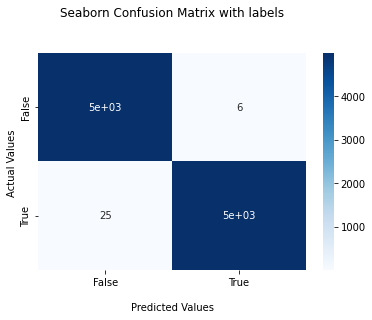

In [ ]:
labels = np.array([])
pred = np.array([])
for x, y in val_dataset:
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])
  pred = np.concatenate([pred, np.argmax(net_fc.predict(x), axis=-1)])


fpr, tpr, _ = roc_curve(labels, pred)
print(f'Sensitivity: {tpr[1]}')
cf_matrix = confusion_matrix(labels, pred)
grafico(cf_matrix, 'net_fc.png')

## **Visualization of the learning curves**


### **Loss**


<IPython.core.display.Javascript object>

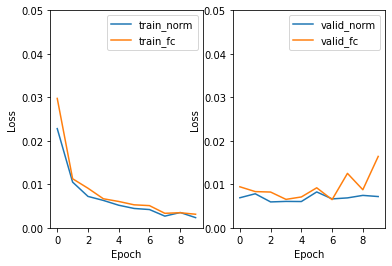

In [ ]:
#Plot the loss
plt.subplot(1, 2, 1)
plt.plot(history_norm.history['loss'])
plt.plot(history_fc.history['loss'])
plt.ylim([0.0, 0.05])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train_norm', 'train_fc' ])

plt.subplot(1, 2, 2)
plt.plot(history_norm.history['val_loss'])
plt.plot(history_fc.history['val_loss'])
plt.ylim([0.0, 0.05])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['valid_norm','valid_fc' ])
plt.savefig('fc_loss.png')

### **Accuracy**


<IPython.core.display.Javascript object>

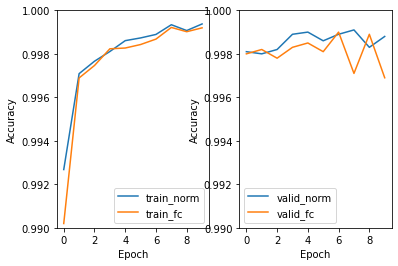

In [ ]:
#plot the accuracy
plt.subplot(1, 2, 1)
plt.plot(history_norm.history['accuracy'])
plt.plot(history_fc.history['accuracy'])
plt.ylim([0.99, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train_norm', 'train_fc' ])

plt.subplot(1, 2, 2)
plt.plot(history_norm.history['val_accuracy'])
plt.plot(history_fc.history['val_accuracy'])
plt.ylim([0.99, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['valid_norm','valid_fc' ])
plt.savefig('fc_accuracy.png')

ESCLUDIAMO IL LAYER FULLY CONNECTED

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>
_________________________________________________________________________

#**BW**

##**Generate the black&white images**

In [ ]:
#create a new folder, like new_data, where to put the black and white images
os.mkdir('new_data_bw')
os.mkdir('new_data_bw/test')
os.mkdir('new_data_bw/training')
os.mkdir('new_data_bw/test/Negative')
os.mkdir('new_data_bw/test/Positive')
os.mkdir('new_data_bw/training/Negative')
os.mkdir('new_data_bw/training/Positive')

#populate the folder
for path in ['test/Negative','test/Positive','training/Negative','training/Positive']:
  for _ in os.listdir(f'new_data/{path}'):
    img = cv2.imread( f'new_data/{path}/{_}',0) #image read in greyscale 
    cv2.imwrite(f'new_data_bw/{path}/{_}',img)

<IPython.core.display.Javascript object>

In [ ]:
train_path='new_data_bw/training'
train_dataset_bw = keras.preprocessing.image_dataset_from_directory(train_path,
                                                            image_size=(227,227),
                                                            color_mode='rgb',
                                                            batch_size=32,
                                                            label_mode='categorical',
                                                            subset='training',
                                                            validation_split = VAL_SPLIT,
                                                            shuffle=True,
                                                            seed=1)

val_dataset_bw = keras.preprocessing.image_dataset_from_directory(train_path,
                                                            image_size=(227,227),
                                                            color_mode='rgb',
                                                            batch_size=32,
                                                            label_mode='categorical',
                                                            subset='validation',
                                                            validation_split = VAL_SPLIT,
                                                            shuffle=True,
                                                            seed=1)


<IPython.core.display.Javascript object>

Found 56000 files belonging to 2 classes.
Using 46000 files for training.
Found 56000 files belonging to 2 classes.
Using 10000 files for validation.


##**Architecture Definition**

In [ ]:
# Architecture definition v1
inputs = keras.Input((227,227,3)) #raw,columns,channels(RGB)

x = inputs
x = keras.layers.Conv2D(8, 3, padding="same")(x) #32 filters 3x3, "same" chose automatically the padding dimension
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x) #activation function is ReLU
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x) #filter dimension = 3, stripe = 3

x = keras.layers.Conv2D(16, 3, padding="same")(x) #altro layer convoluzionale
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x) #filter dimension = 3, stripe = 3

x = keras.layers.Conv2D(16, 3, padding="same")(x) #altro layer convoluzionale
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x) #filter dimension = 3, stripe = 3

x = keras.layers.Conv2D(32, 3, padding="same")(x) #altro layer convoluzionale
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x) #filter dimension = 3, stripe = 3

x = keras.layers.Conv2D(32, 3, padding="same")(x) #altro layer convoluzionale
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)

x = keras.layers.GlobalMaxPooling2D()(x)

outputs = keras.layers.Dense(num_classes, activation="softmax")(x) #output layer, we use softmax cause is the common one
net_bw = keras.Model(inputs, outputs) #construction of the model


# Compile the model for training
net_bw.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy'])


# Model training (v1)
history_bw = net_bw.fit(train_dataset_bw,
          epochs=10,
          validation_data=val_dataset_bw);

##**Saving of the History in Google Drive**

In [ ]:
name='net_bw_1_new_data'
joblib.dump(net_bw, f'{name}.sav')
np.save(f'{name}_history.npy',history_bw)
copyfile(f'{name}.sav', f'gdrive/My Drive/FDL_project/saves/{name}.sav')
copyfile(f'{name}_history.npy', f'gdrive/My Drive/FDL_project/saves/{name}_history.npy')

##**Confusion Matrix**

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Sensitivity: 0.9987971130713713


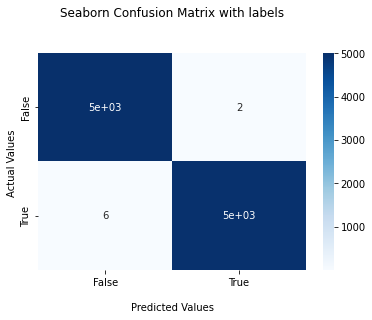

In [ ]:
labels = np.array([])
pred = np.array([])
for x, y in val_dataset_bw:
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])
  pred = np.concatenate([pred, np.argmax(net_bw.predict(x), axis=-1)])


fpr, tpr, _ = roc_curve(labels, pred)
print(f'Sensitivity: {tpr[1]}')
cf_matrix = confusion_matrix(labels, pred)
grafico(cf_matrix, 'net_bw.png')

##**Visualize the results**

###**Loss**

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

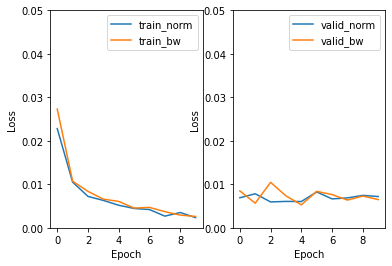

In [ ]:
#Plot the loss
plt.subplot(1, 2, 1)
plt.plot(history_norm.history['loss'])
plt.plot(history_bw.history['loss'])
plt.ylim([0.0, 0.05])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train_norm', 'train_bw' ])

plt.subplot(1, 2, 2)
plt.plot(history_norm.history['val_loss'])
plt.plot(history_bw.history['val_loss'])
plt.ylim([0.0, 0.05])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['valid_norm','valid_bw' ])
plt.savefig('bw_loss.png')

###**Accuracy**

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

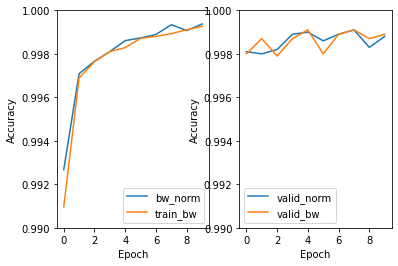

In [ ]:
#plot the accuracy
plt.subplot(1, 2, 1)
plt.plot(history_norm.history['accuracy'])
plt.plot(history_bw.history['accuracy'])
plt.ylim([0.99, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['bw_norm', 'train_bw' ])

plt.subplot(1, 2, 2)
plt.plot(history_norm.history['val_accuracy'])
plt.plot(history_bw.history['val_accuracy'])
plt.ylim([0.99, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['valid_norm','valid_bw' ])
plt.savefig('bw_accuracy.png')

<br><br><br><br><br>
#**FINAL RESULTS**

##**Data Loader for full_train and test set** 

In [ ]:
train_path='new_data/training'
train_dataset_full = keras.preprocessing.image_dataset_from_directory(train_path,
                                                            image_size=(227,227),
                                                            color_mode='rgb',
                                                            batch_size=32,
                                                            label_mode='categorical',
                                                            shuffle=True,
                                                            seed=1)
test_path='new_data/test'
test_dataset = keras.preprocessing.image_dataset_from_directory(test_path,
                                                            image_size=(227,227),
                                                            color_mode='rgb',
                                                            batch_size=32,
                                                            label_mode='categorical',
                                                            shuffle=True,
                                                            seed=1)

<IPython.core.display.Javascript object>

Found 56000 files belonging to 2 classes.
Found 10000 files belonging to 2 classes.


##**NORM**

In [ ]:
# Architecture definition v1
inputs = keras.Input((227,227,3)) #raw,columns,channels(RGB)

x = inputs
x = keras.layers.Conv2D(8, 3, padding="same")(x) #32 filters 3x3, "same" chose automatically the padding dimension
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x) #activation function is ReLU
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x) #filter dimension = 3, stripe = 3

x = keras.layers.Conv2D(16, 3, padding="same")(x) #altro layer convoluzionale
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x) #filter dimension = 3, stripe = 3

x = keras.layers.Conv2D(16, 3, padding="same")(x) #altro layer convoluzionale
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x) #filter dimension = 3, stripe = 3

x = keras.layers.Conv2D(32, 3, padding="same")(x) #altro layer convoluzionale
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x) #filter dimension = 3, stripe = 3

x = keras.layers.Conv2D(32, 3, padding="same")(x) #altro layer convoluzionale
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)

x = keras.layers.GlobalMaxPooling2D()(x)

outputs = keras.layers.Dense(num_classes, activation="softmax")(x) #output layer, we use softmax cause is the common one
net_norm_final = keras.Model(inputs, outputs) #construction of the model

# Compile the model for training
net_norm_final.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy'])

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5) #if in 5 consecutive epochs there are no improvments, stop

# Model training (v1)
history_norm_final = net_norm_final.fit(train_dataset_full,
          epochs=40,
          validation_data=test_dataset,
          callbacks=[callback] );

#stops after 15 epochs

<IPython.core.display.Javascript object>

Epoch 1/25
1750/1750 [==============================] - 146s 72ms/step - loss: 0.0226 - accuracy: 0.9927 - val_loss: 0.0124 - val_accuracy: 0.9969
Epoch 2/25
1750/1750 [==============================] - 106s 60ms/step - loss: 0.0099 - accuracy: 0.9973 - val_loss: 0.0119 - val_accuracy: 0.9973
Epoch 3/25
1750/1750 [==============================] - 107s 61ms/step - loss: 0.0080 - accuracy: 0.9975 - val_loss: 0.0130 - val_accuracy: 0.9966
Epoch 4/25
1750/1750 [==============================] - 105s 60ms/step - loss: 0.0052 - accuracy: 0.9984 - val_loss: 0.0109 - val_accuracy: 0.9977
Epoch 5/25
1750/1750 [==============================] - 105s 60ms/step - loss: 0.0050 - accuracy: 0.9986 - val_loss: 0.0115 - val_accuracy: 0.9980
Epoch 6/25
1750/1750 [==============================] - 103s 59ms/step - loss: 0.0040 - accuracy: 0.9990 - val_loss: 0.0104 - val_accuracy: 0.9980
Epoch 7/25
1750/1750 [==============================] - 106s 60ms/step - loss: 0.0034 - accuracy: 0.9991 - val_loss: 0

In [ ]:
name='net_norm_final_1_new_data'
joblib.dump(net_norm_final, f'{name}.sav')
np.save(f'{name}_history.npy',history_norm_final)
copyfile(f'{name}.sav', f'gdrive/My Drive/FDL_project/saves/{name}.sav')
copyfile(f'{name}_history.npy', f'gdrive/My Drive/FDL_project/saves/{name}_history.npy')

<IPython.core.display.Javascript object>

INFO:tensorflow:Assets written to: ram://7bdc4f63-d530-411a-b6a6-037d82e22d0b/assets
INFO:tensorflow:Assets written to: ram://8329c386-afa1-46b2-b1f0-f56103b05153/assets


'gdrive/My Drive/FDL_project/saves/net_norm_final_1_new_data_history.npy'

<IPython.core.display.Javascript object>

Sensitivity: 0.9984


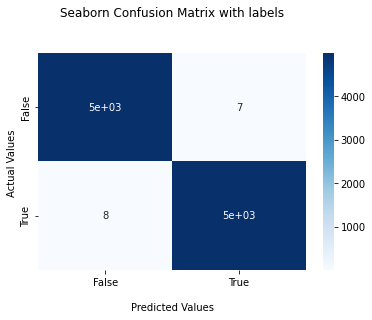

In [ ]:
labels = np.array([])
pred = np.array([])
for x, y in test_dataset:
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])
  pred = np.concatenate([pred, np.argmax(net_norm_final.predict(x), axis=-1)])


fpr, tpr, _ = roc_curve(labels, pred)
print(f'Sensitivity: {tpr[1]}')
cf_matrix = confusion_matrix(labels, pred)
grafico(cf_matrix, 'TEST_________net_norm_final.png')

##**NORM_S4**

In [ ]:
inputs = keras.Input((227,227,3))

x = inputs
x = keras.layers.Conv2D(8, 3, padding="same")(x) 
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x) 
x = keras.layers.MaxPooling2D(3, strides=4, padding="same")(x) 

x = keras.layers.Conv2D(16, 3, padding="same")(x) 
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=4, padding="same")(x) 

x = keras.layers.Conv2D(16, 3, padding="same")(x) 
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=4, padding="same")(x) 

x = keras.layers.Conv2D(32, 3, padding="same")(x) 
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=4, padding="same")(x) 

x = keras.layers.Conv2D(32, 3, padding="same")(x) 
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)

x = keras.layers.GlobalMaxPooling2D()(x)

outputs = keras.layers.Dense(num_classes, activation="softmax")(x)
net_norm_s4_final = keras.Model(inputs, outputs) 



net_norm_s4_final.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy'])

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5) #if in 5 consecutive epochs there are no improvments, stop

history_norm_s4_final = net_norm_s4_final.fit(train_dataset_full,
          epochs=40,
          validation_data=test_dataset,
          callbacks=[callback] );

<IPython.core.display.Javascript object>

Epoch 1/25
1750/1750 [==============================] - 114s 64ms/step - loss: 0.0295 - accuracy: 0.9904 - val_loss: 0.0188 - val_accuracy: 0.9956
Epoch 2/25
1750/1750 [==============================] - 108s 62ms/step - loss: 0.0166 - accuracy: 0.9948 - val_loss: 0.0144 - val_accuracy: 0.9966
Epoch 3/25
1750/1750 [==============================] - 113s 64ms/step - loss: 0.0131 - accuracy: 0.9965 - val_loss: 0.0150 - val_accuracy: 0.9967
Epoch 4/25
1750/1750 [==============================] - 126s 72ms/step - loss: 0.0119 - accuracy: 0.9967 - val_loss: 0.0148 - val_accuracy: 0.9967
Epoch 5/25
1750/1750 [==============================] - 107s 61ms/step - loss: 0.0114 - accuracy: 0.9969 - val_loss: 0.0150 - val_accuracy: 0.9971
Epoch 6/25
1750/1750 [==============================] - 129s 73ms/step - loss: 0.0093 - accuracy: 0.9975 - val_loss: 0.0145 - val_accuracy: 0.9975
Epoch 7/25
1750/1750 [==============================] - 126s 72ms/step - loss: 0.0090 - accuracy: 0.9974 - val_loss: 0

In [ ]:
name='net_norm_s4_final_1_new_data'
joblib.dump(net_norm_s4_final, f'{name}.sav')
np.save(f'{name}_history.npy',history_norm_s4_final)
copyfile(f'{name}.sav', f'gdrive/My Drive/FDL_project/saves/{name}.sav')
copyfile(f'{name}_history.npy', f'gdrive/My Drive/FDL_project/saves/{name}_history.npy')

<IPython.core.display.Javascript object>

INFO:tensorflow:Assets written to: ram://abd42d75-bfba-4b74-bf95-61006e8a9b62/assets
INFO:tensorflow:Assets written to: ram://8ca8904b-d58a-4184-8281-93e79822770a/assets


'gdrive/My Drive/FDL_project/saves/net_norm_s4_final_1_new_data_history.npy'

<IPython.core.display.Javascript object>

Sensitivity: 0.998


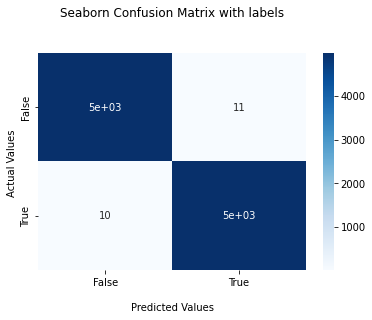

In [ ]:
labels = np.array([])
pred = np.array([])
for x, y in test_dataset:
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])
  pred = np.concatenate([pred, np.argmax(net_norm_s4_final.predict(x), axis=-1)])


fpr, tpr, _ = roc_curve(labels, pred)
print(f'Sensitivity: {tpr[1]}')
cf_matrix = confusion_matrix(labels, pred)
grafico(cf_matrix, 'TEST_________net_norm_s4_final.png')

## **BW**

In [ ]:
train_path='new_data_bw/training'
train_dataset_bw_full = keras.preprocessing.image_dataset_from_directory(train_path,
                                                            image_size=(227,227),
                                                            color_mode='rgb',
                                                            batch_size=32,
                                                            label_mode='categorical',
                                                            shuffle=True,
                                                            seed=1)
test_path='new_data_bw/test'
test_dataset_bw = keras.preprocessing.image_dataset_from_directory(test_path,
                                                            image_size=(227,227),
                                                            color_mode='rgb',
                                                            batch_size=32,
                                                            label_mode='categorical',
                                                            shuffle=True,
                                                            seed=1)

<IPython.core.display.Javascript object>

Found 56000 files belonging to 2 classes.
Found 10000 files belonging to 2 classes.


In [ ]:
# Architecture definition v1
inputs = keras.Input((227,227,3)) #raw,columns,channels(RGB)

x = inputs
x = keras.layers.Conv2D(8, 3, padding="same")(x) #32 filters 3x3, "same" chose automatically the padding dimension
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x) #activation function is ReLU
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x) #filter dimension = 3, stripe = 3

x = keras.layers.Conv2D(16, 3, padding="same")(x) #altro layer convoluzionale
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x) #filter dimension = 3, stripe = 3

x = keras.layers.Conv2D(16, 3, padding="same")(x) #altro layer convoluzionale
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x) #filter dimension = 3, stripe = 3

x = keras.layers.Conv2D(32, 3, padding="same")(x) #altro layer convoluzionale
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x) #filter dimension = 3, stripe = 3

x = keras.layers.Conv2D(32, 3, padding="same")(x) #altro layer convoluzionale
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)

x = keras.layers.GlobalMaxPooling2D()(x)

outputs = keras.layers.Dense(num_classes, activation="softmax")(x) #output layer, we use softmax cause is the common one
net_bw_final = keras.Model(inputs, outputs) #construction of the model


# Compile the model for training
net_bw_final.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy'])

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5) #if in 5 consecutive epochs there are no improvments, stop

# Model training (v1)
history_bw_final = net_bw_final.fit(train_dataset_bw_full,
          epochs=40,
          validation_data=test_dataset_bw,
          callbacks=[callback] );

<IPython.core.display.Javascript object>

Epoch 1/25
1750/1750 [==============================] - 103s 57ms/step - loss: 0.0219 - accuracy: 0.9927 - val_loss: 0.0146 - val_accuracy: 0.9962
Epoch 2/25
1750/1750 [==============================] - 102s 58ms/step - loss: 0.0095 - accuracy: 0.9971 - val_loss: 0.0139 - val_accuracy: 0.9956
Epoch 3/25
1750/1750 [==============================] - 101s 58ms/step - loss: 0.0076 - accuracy: 0.9977 - val_loss: 0.0094 - val_accuracy: 0.9981
Epoch 4/25
1750/1750 [==============================] - 99s 57ms/step - loss: 0.0052 - accuracy: 0.9984 - val_loss: 0.0170 - val_accuracy: 0.9962
Epoch 5/25
1750/1750 [==============================] - 100s 57ms/step - loss: 0.0050 - accuracy: 0.9988 - val_loss: 0.0138 - val_accuracy: 0.9975
Epoch 6/25
1750/1750 [==============================] - 99s 57ms/step - loss: 0.0041 - accuracy: 0.9989 - val_loss: 0.0124 - val_accuracy: 0.9978
Epoch 7/25
1750/1750 [==============================] - 117s 66ms/step - loss: 0.0031 - accuracy: 0.9991 - val_loss: 0.0

In [ ]:
name='net_bw_final_1_new_data'
joblib.dump(net_bw_final, f'{name}.sav')
np.save(f'{name}_history.npy',history_bw_final)
copyfile(f'{name}.sav', f'gdrive/My Drive/FDL_project/saves/{name}.sav')
copyfile(f'{name}_history.npy', f'gdrive/My Drive/FDL_project/saves/{name}_history.npy')

<IPython.core.display.Javascript object>

INFO:tensorflow:Assets written to: ram://1940cc3d-e6e1-430d-8946-4ebdb397c5ec/assets
INFO:tensorflow:Assets written to: ram://101ade73-cbce-44fb-8f31-d34848ca5a4e/assets


'gdrive/My Drive/FDL_project/saves/net_bw_final_1_new_data_history.npy'

<IPython.core.display.Javascript object>

Sensitivity: 0.9976


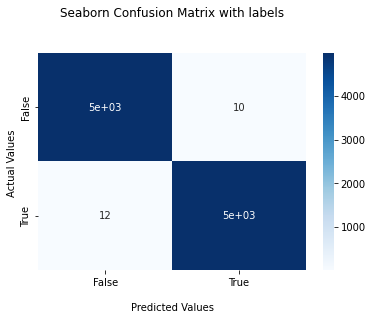

In [ ]:
labels = np.array([])
pred = np.array([])
for x, y in test_dataset_bw:
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])
  pred = np.concatenate([pred, np.argmax(net_bw_final.predict(x), axis=-1)])


fpr, tpr, _ = roc_curve(labels, pred)
print(f'Sensitivity: {tpr[1]}')
cf_matrix = confusion_matrix(labels, pred)
grafico(cf_matrix, 'TEST_________net_bw_final.png')

#FEATURE MAP EXAMPLE

In [ ]:
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims
import matplotlib.image as mpimg

def plot_feature_map(lev,x,y,img_path):
  # load the model
  model = net_norm_final
  # redefine model to output right after the first hidden layer
  model = Model(inputs=model.inputs, outputs=model.layers[lev].output)
  model.summary()
  # load the image with the required shape
  img = load_img(img_path, target_size=(227, 227))
  # convert the image to an array
  img = img_to_array(img)
  # expand dimensions so that it represents a single 'sample'
  img = expand_dims(img, axis=0)
  # prepare the image (e.g. scale pixel values for the vgg)
  img = preprocess_input(img)
  # get feature map for first hidden layer
  feature_maps = model.predict(img)
  # plot all 64 maps in an 8x8 squares
  square = x
  ix = 1
  for _ in range(square):
    for _ in range(square-(x-y)):
      # specify subplot and turn of axis
      ax = pyplot.subplot(square, square, ix)
      ax.set_xticks([])
      ax.set_yticks([])
      # plot filter channel in grayscale
      pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
      ix += 1
      
  # show the figure
  pyplot.show()

<IPython.core.display.Javascript object>

In [ ]:
img_path='new_data/test/Positive/00198.jpg'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

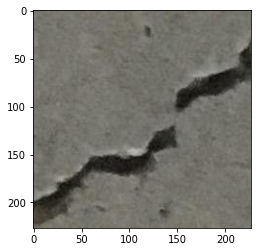

In [ ]:
plt.imshow(mpimg.imread(img_path))


<IPython.core.display.Javascript object>

Model: "model_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 227, 227, 8)       224       
                                                                 
Total params: 224
Trainable params: 224
Non-trainable params: 0
_________________________________________________________________


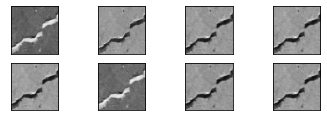

In [ ]:
plot_feature_map(1,4,2, img_path)


<IPython.core.display.Javascript object>

Model: "model_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 227, 227, 8)       224       
                                                                 
 batch_normalization (BatchN  (None, 227, 227, 8)      32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 227, 227, 8)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 76, 76, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 76, 76, 16)        116

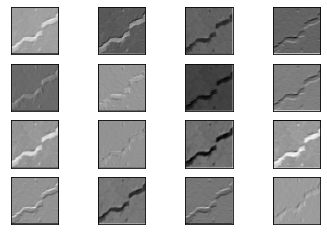

In [ ]:
plot_feature_map(5,4,4,img_path)

<IPython.core.display.Javascript object>

Model: "model_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 227, 227, 8)       224       
                                                                 
 batch_normalization (BatchN  (None, 227, 227, 8)      32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 227, 227, 8)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 76, 76, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 76, 76, 16)        116

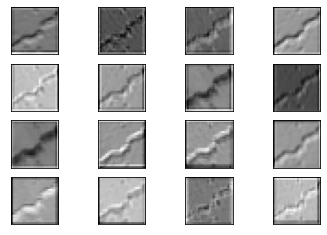

In [ ]:
plot_feature_map(9,4,4, img_path)

<IPython.core.display.Javascript object>

Model: "model_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 227, 227, 8)       224       
                                                                 
 batch_normalization (BatchN  (None, 227, 227, 8)      32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 227, 227, 8)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 76, 76, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 76, 76, 16)        116

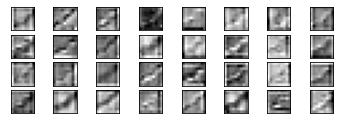

In [ ]:
plot_feature_map(13,8,4, img_path)

<IPython.core.display.Javascript object>

Model: "model_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 227, 227, 8)       224       
                                                                 
 batch_normalization (BatchN  (None, 227, 227, 8)      32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 227, 227, 8)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 76, 76, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 76, 76, 16)        116

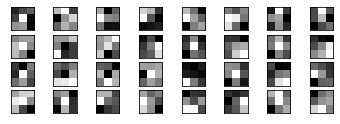

In [ ]:
plot_feature_map(17,8,4,img_path)